# Experiments to improve classification accuracy

In [1]:
from IPython.display import display
import pandas as pd
import pylab
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

pylab.rcParams['figure.figsize'] = (10, 5)

## First, let's look at the baseline results

In [2]:
LANGUAGE_CODE_TO_NAME = {
    'af': 'Afrikaans',
    'ar': 'Arabic',
    'bg': 'Bulgarian',
    'bn': 'Bengali',
    'ca': 'Catalan',
    'cs': 'Czech',
    'da': 'Danish',
    'de': 'German',
    'el': 'Greek',
    'en': 'English',
    'es': 'Spanish',
    'et': 'Estonian',
    'fa': 'Persian',
    'fi': 'Finnish',
    'fr': 'French',
    'gu': 'Gujarati',
    'he': 'Hebrew',
    'hi': 'Hindi',
    'hr': 'Croatian',
    'hu': 'Hungarian',
    'id': 'Indonesian',
    'it': 'Italian',
    'ja': 'Japanese',
    'kn': 'Kannada',
    'ko': 'Korean',
    'lt': 'Lithuanian',
    'lv': 'Latvian',
    'mk': 'Macedonian',
    'ml': 'Malayalam',
    'mr': 'Marathi',
    'ne': 'Nepali',
    'nl': 'Dutch',
    'no': 'Norwegian',
    'pa': 'Punjabi',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'ru': 'Russian',
    'si': 'Sinhalese',
    'sk': 'Slovak',
    'sl': 'Slovene',
    'so': 'Somali',
    'sq': 'Albanian',
    'sv': 'Swedish',
    'sw': 'Swahili',
    'ta': 'Tamil',
    'te': 'Telugu',
    'th': 'Thai',
    'tl': 'Tagalog',
    'tr': 'Turkish',
    'uk': 'Ukrainian',
    'ur': 'Urdu',
    'vi': 'Vietnamese',
    'zh-cn': 'Simplified Chinese',
    'zh-tw': 'Traditional Chinese'
}

RESULT_PARAM_COLS = ['datasetName', 'substringLength', 'sampleSize', 'useShortProfile', 'useAllLanguages']

In [3]:
baseline_results = pd.read_csv('../src/test/resources/org/xbib/elasticsearch/index/mapper/langdetect/accuracies.csv')
baseline_results.T.head(10).T.head()

,datasetName,substringLength,sampleSize,useShortProfile,useAllLanguages,af,ar,bg,bn,ca
0,udhr,5,100,True,False,NaN,0.83,0.45,1,NaN
1,udhr,10,100,True,False,NaN,0.97,0.64,1,NaN
2,udhr,20,100,True,False,NaN,0.99,0.91,1,NaN
3,udhr,50,100,True,False,NaN,1,0.93,1,NaN
4,udhr,100,100,True,False,NaN,1,1,1,NaN


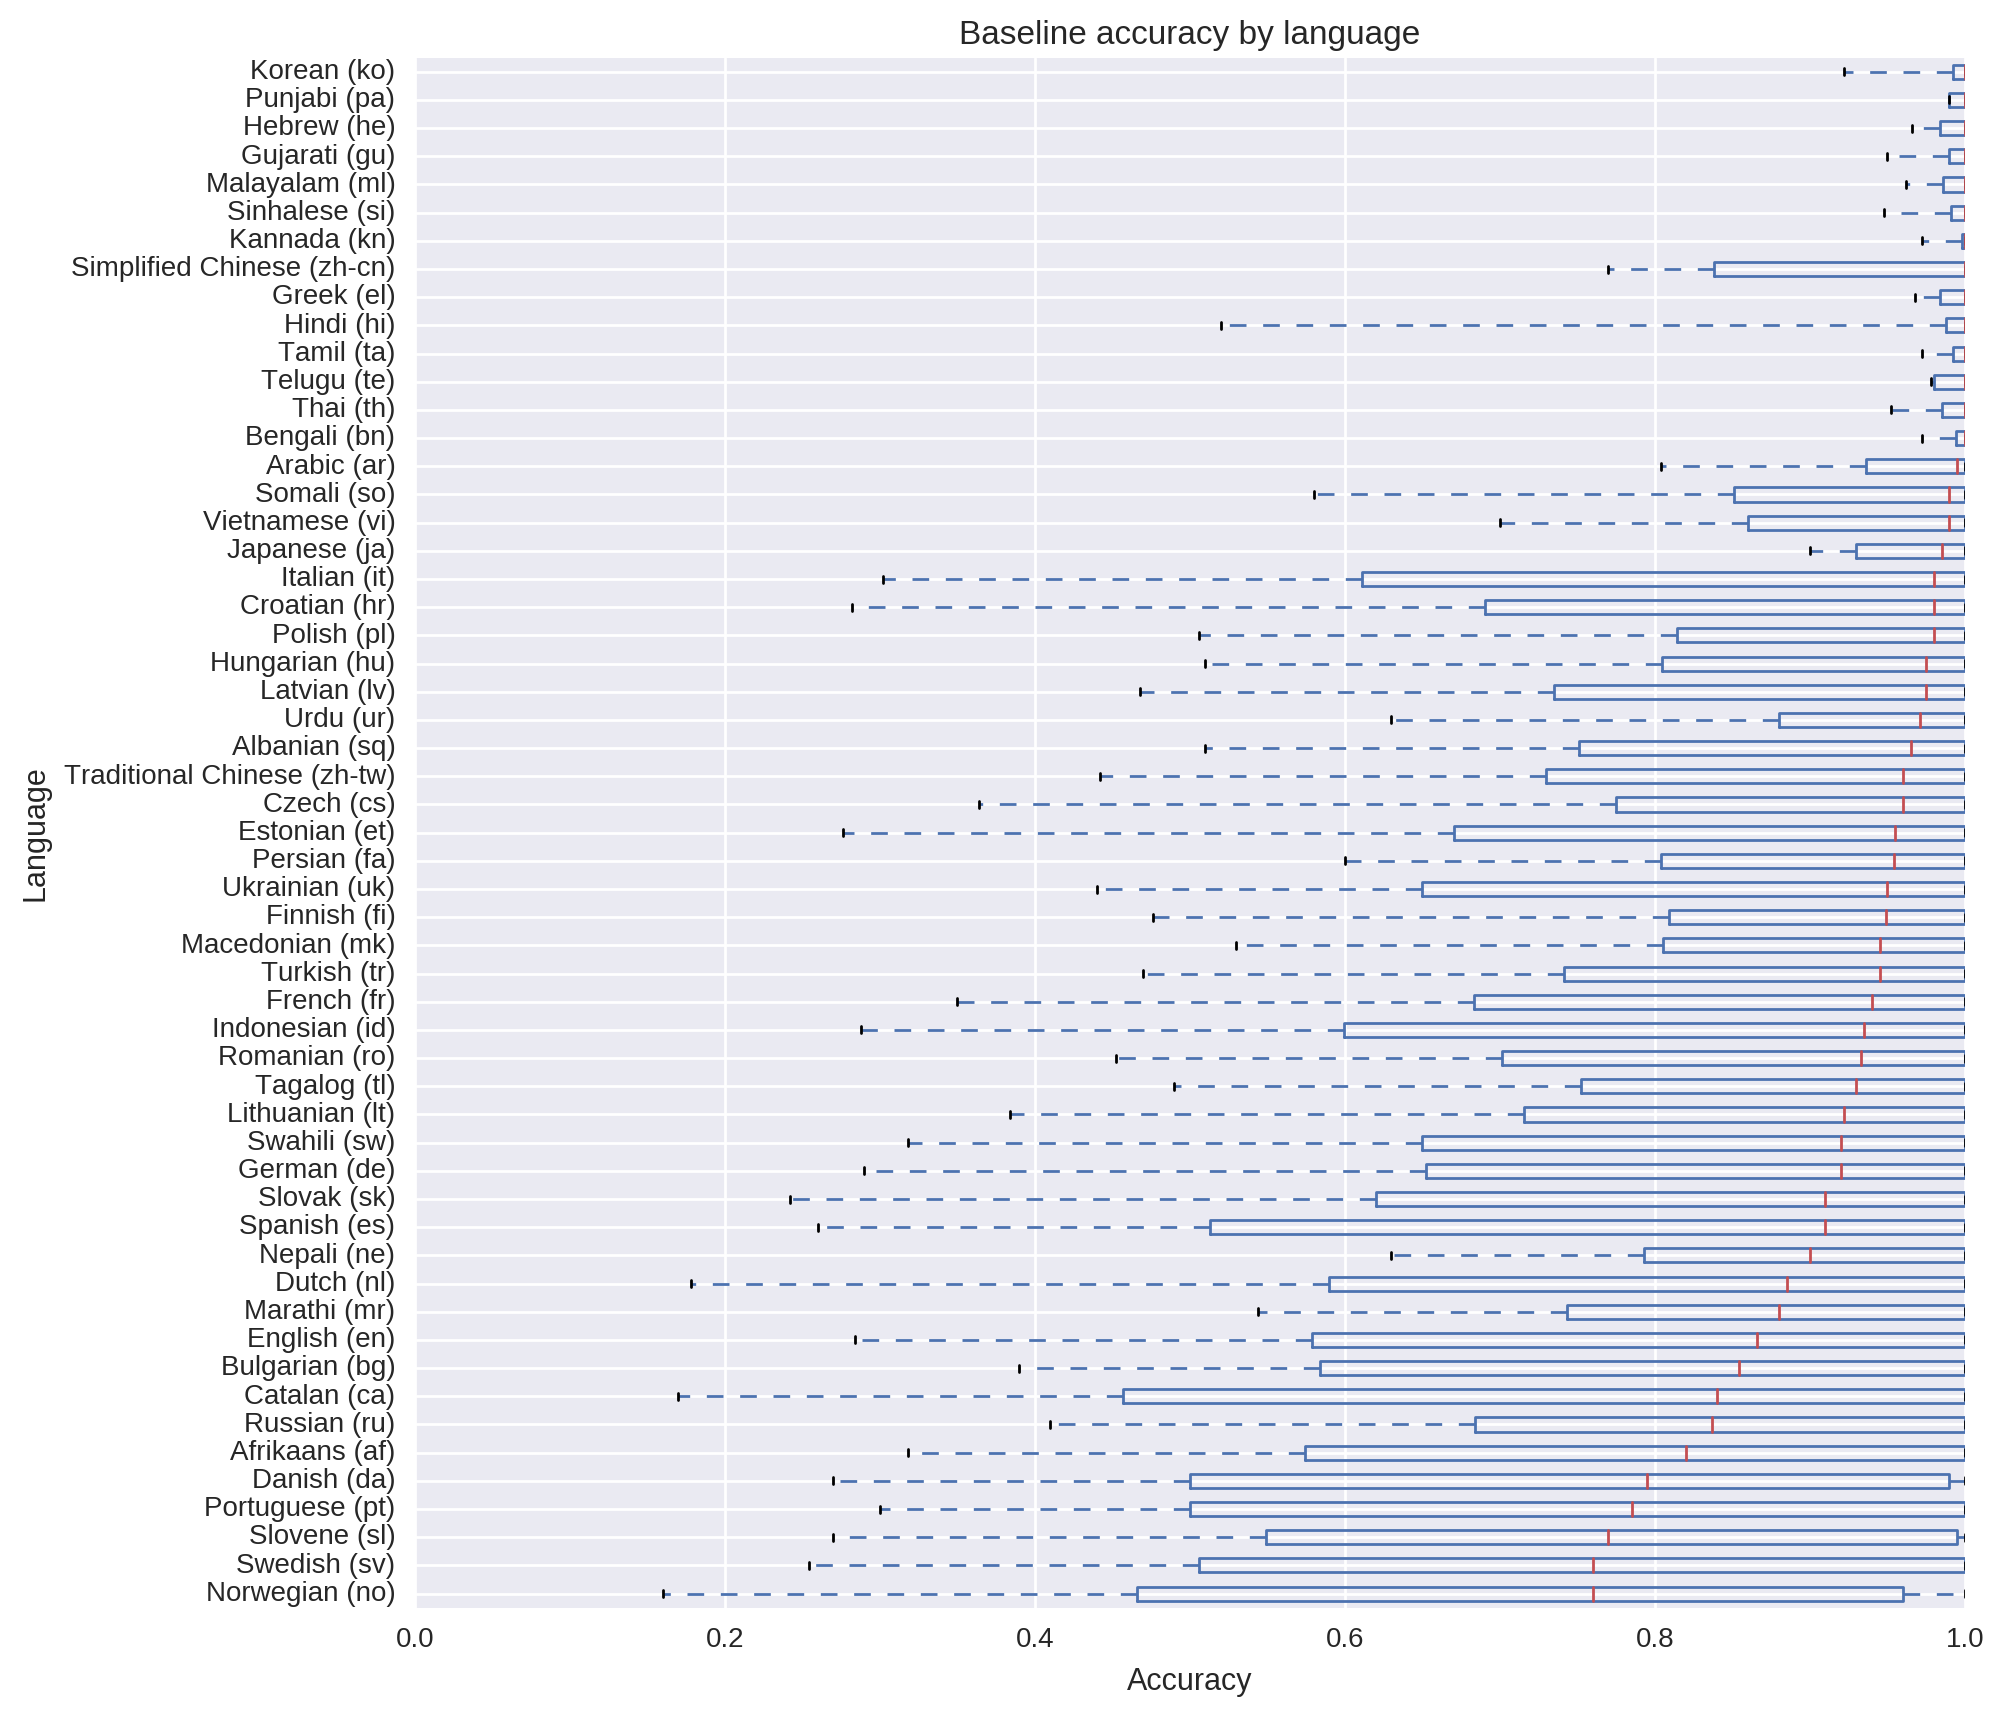

In [4]:
def extract_accuracies(results):
    accuracies = results.drop(RESULT_PARAM_COLS, axis=1)
    accuracies.rename_axis({k: '{} ({})'.format(v, k) for k, v in LANGUAGE_CODE_TO_NAME.items()},
                           axis=1, inplace=True)
    return accuracies

def plot_accuracy_by_language(results, name):
    accuracies = extract_accuracies(results)
    ax = accuracies[accuracies.median().sort_values().index].plot(
        kind='box', vert=False, figsize=(10, 10), whis='range'
    )
    ax.set_xlim((0.0, 1.0))
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Language')
    ax.set_title('{} accuracy by language'.format(name))

plot_accuracy_by_language(baseline_results, 'Baseline')

## Now, let's run a little experiment

In [5]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=no-ngram-subsampling \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/no-ngram-subsampling.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 53.313 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


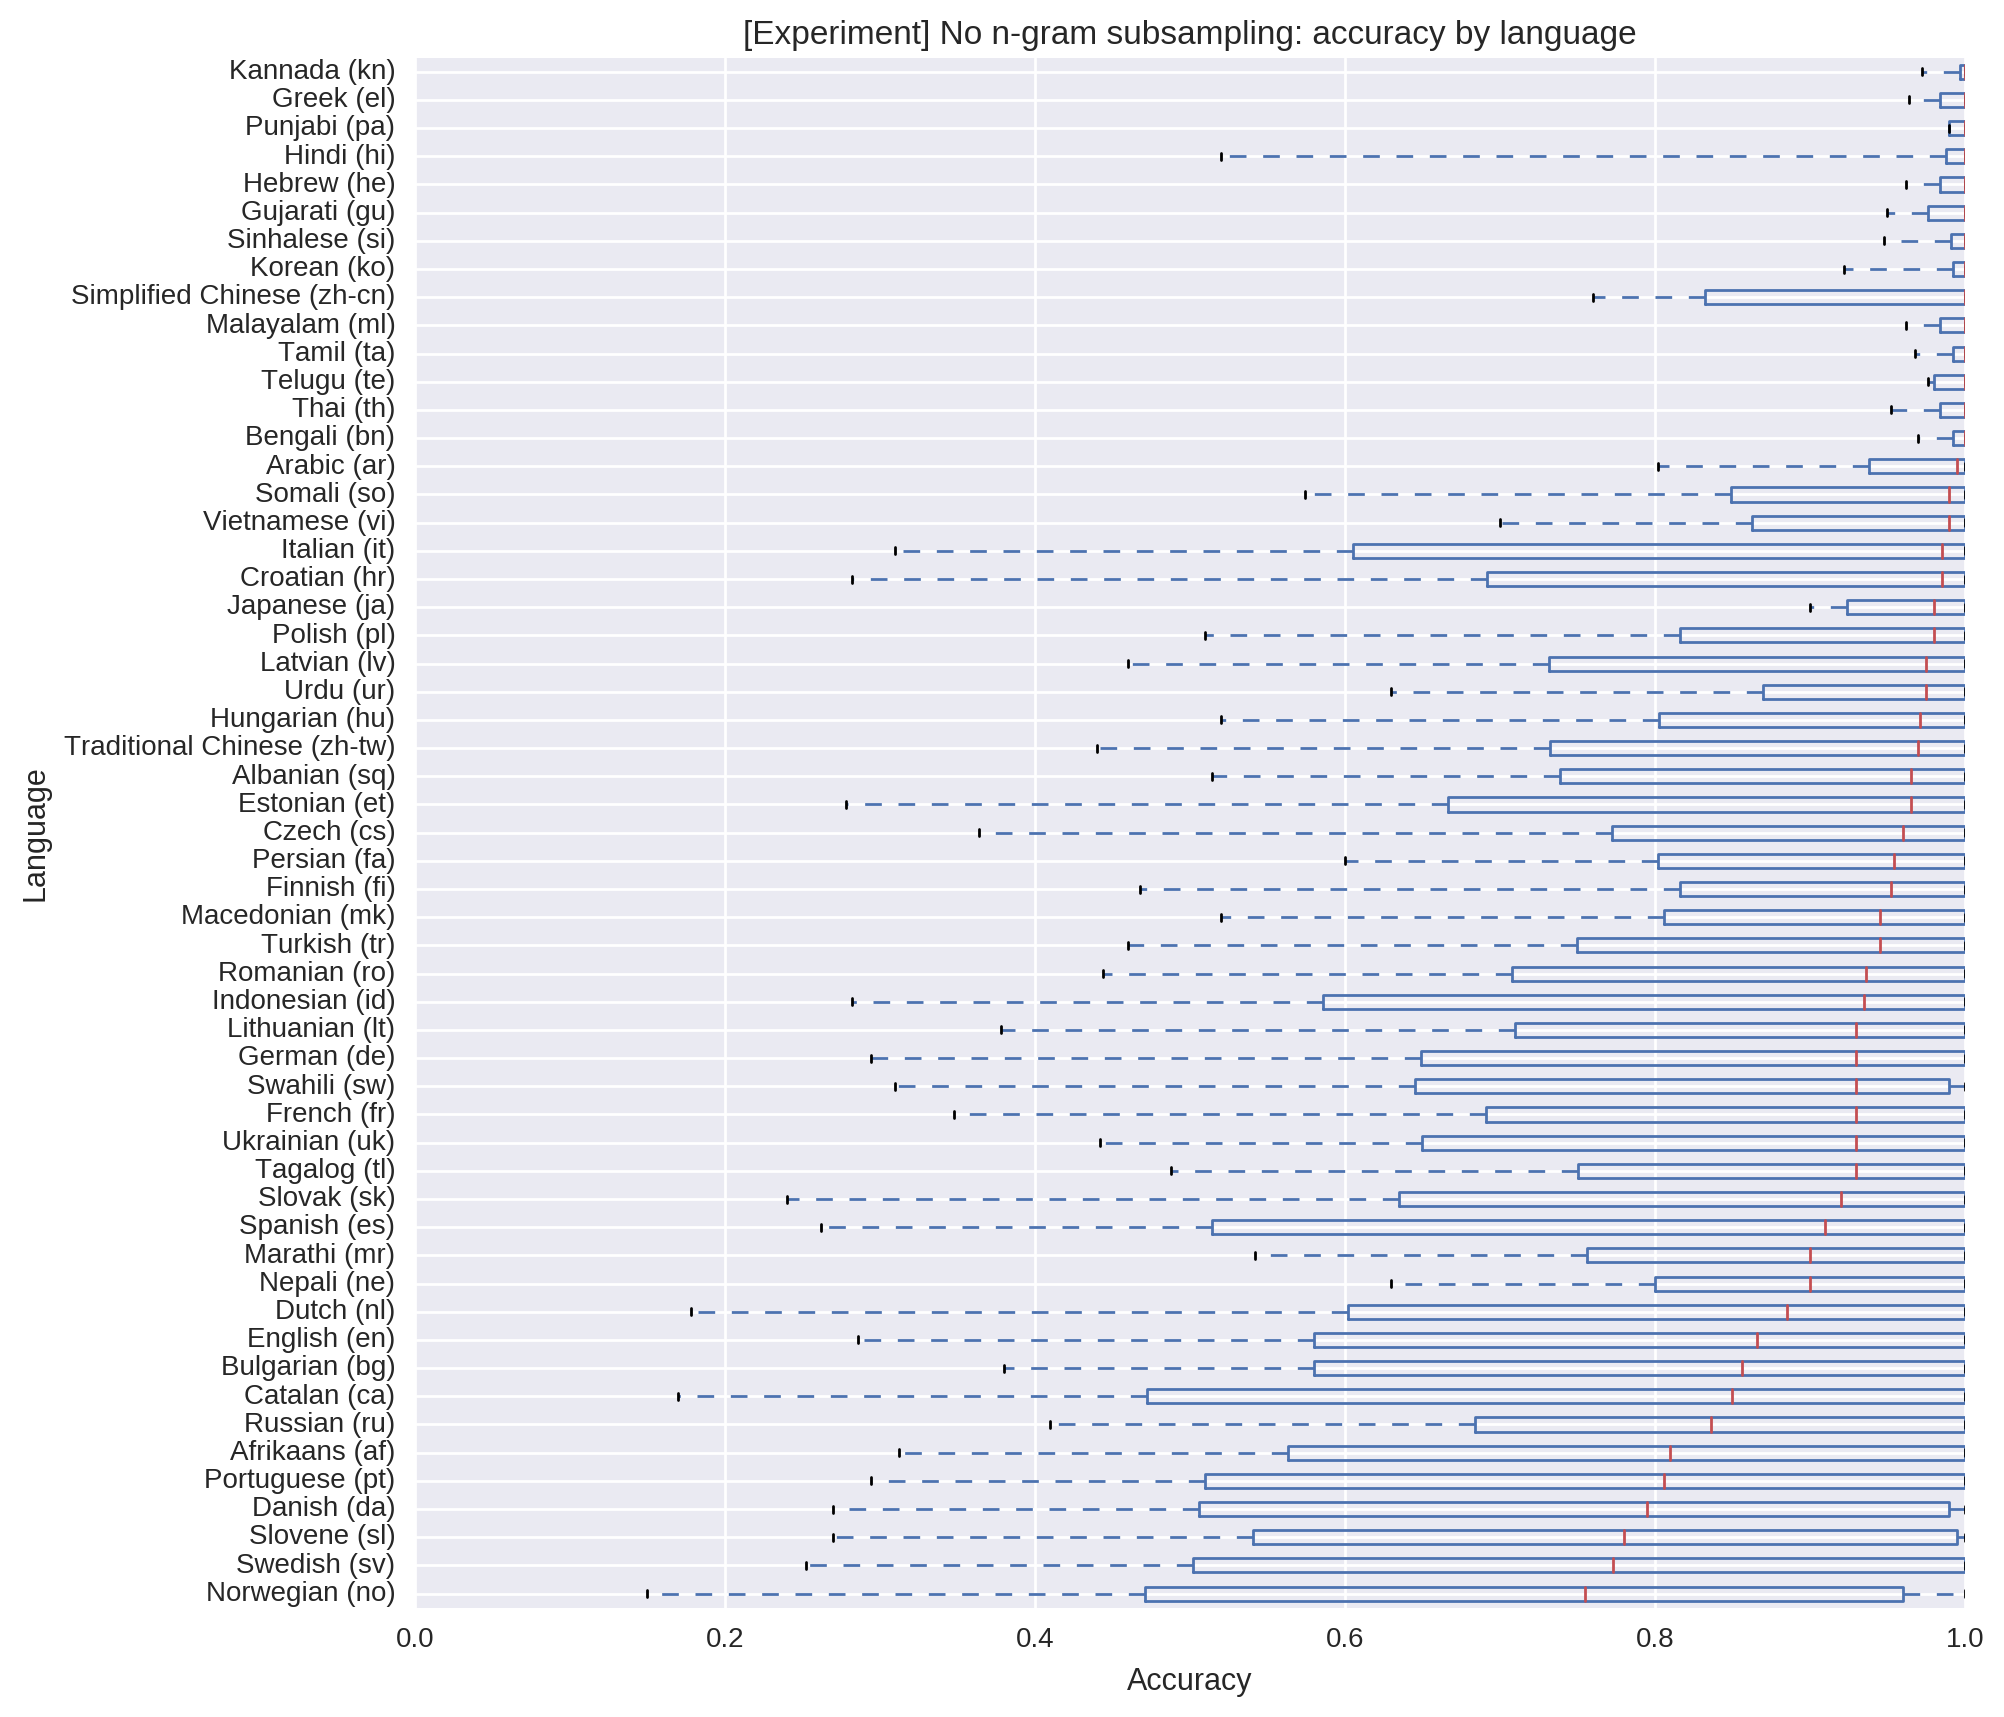

In [6]:
no_ngram_subsampling_results = pd.read_csv('results/no-ngram-subsampling.csv')
plot_accuracy_by_language(no_ngram_subsampling_results, '[Experiment] No n-gram subsampling:')

### Doesn't look that different &ndash; better look at the accuracy deltas to see how our experiment results compare to the baseline

Unfortunately, it doesn't like there's much of a difference... If anything, it is slightly negative. Better run other experiments!

Result summary (positive is better than the baseline)

Number of results: 2090
Number of languages: 55
Mean non-zero delta: -0.001377


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,386,0.184689,37,0.672727
positive,292,0.139713,17,0.309091
zero,1412,0.675598,1,0.018182


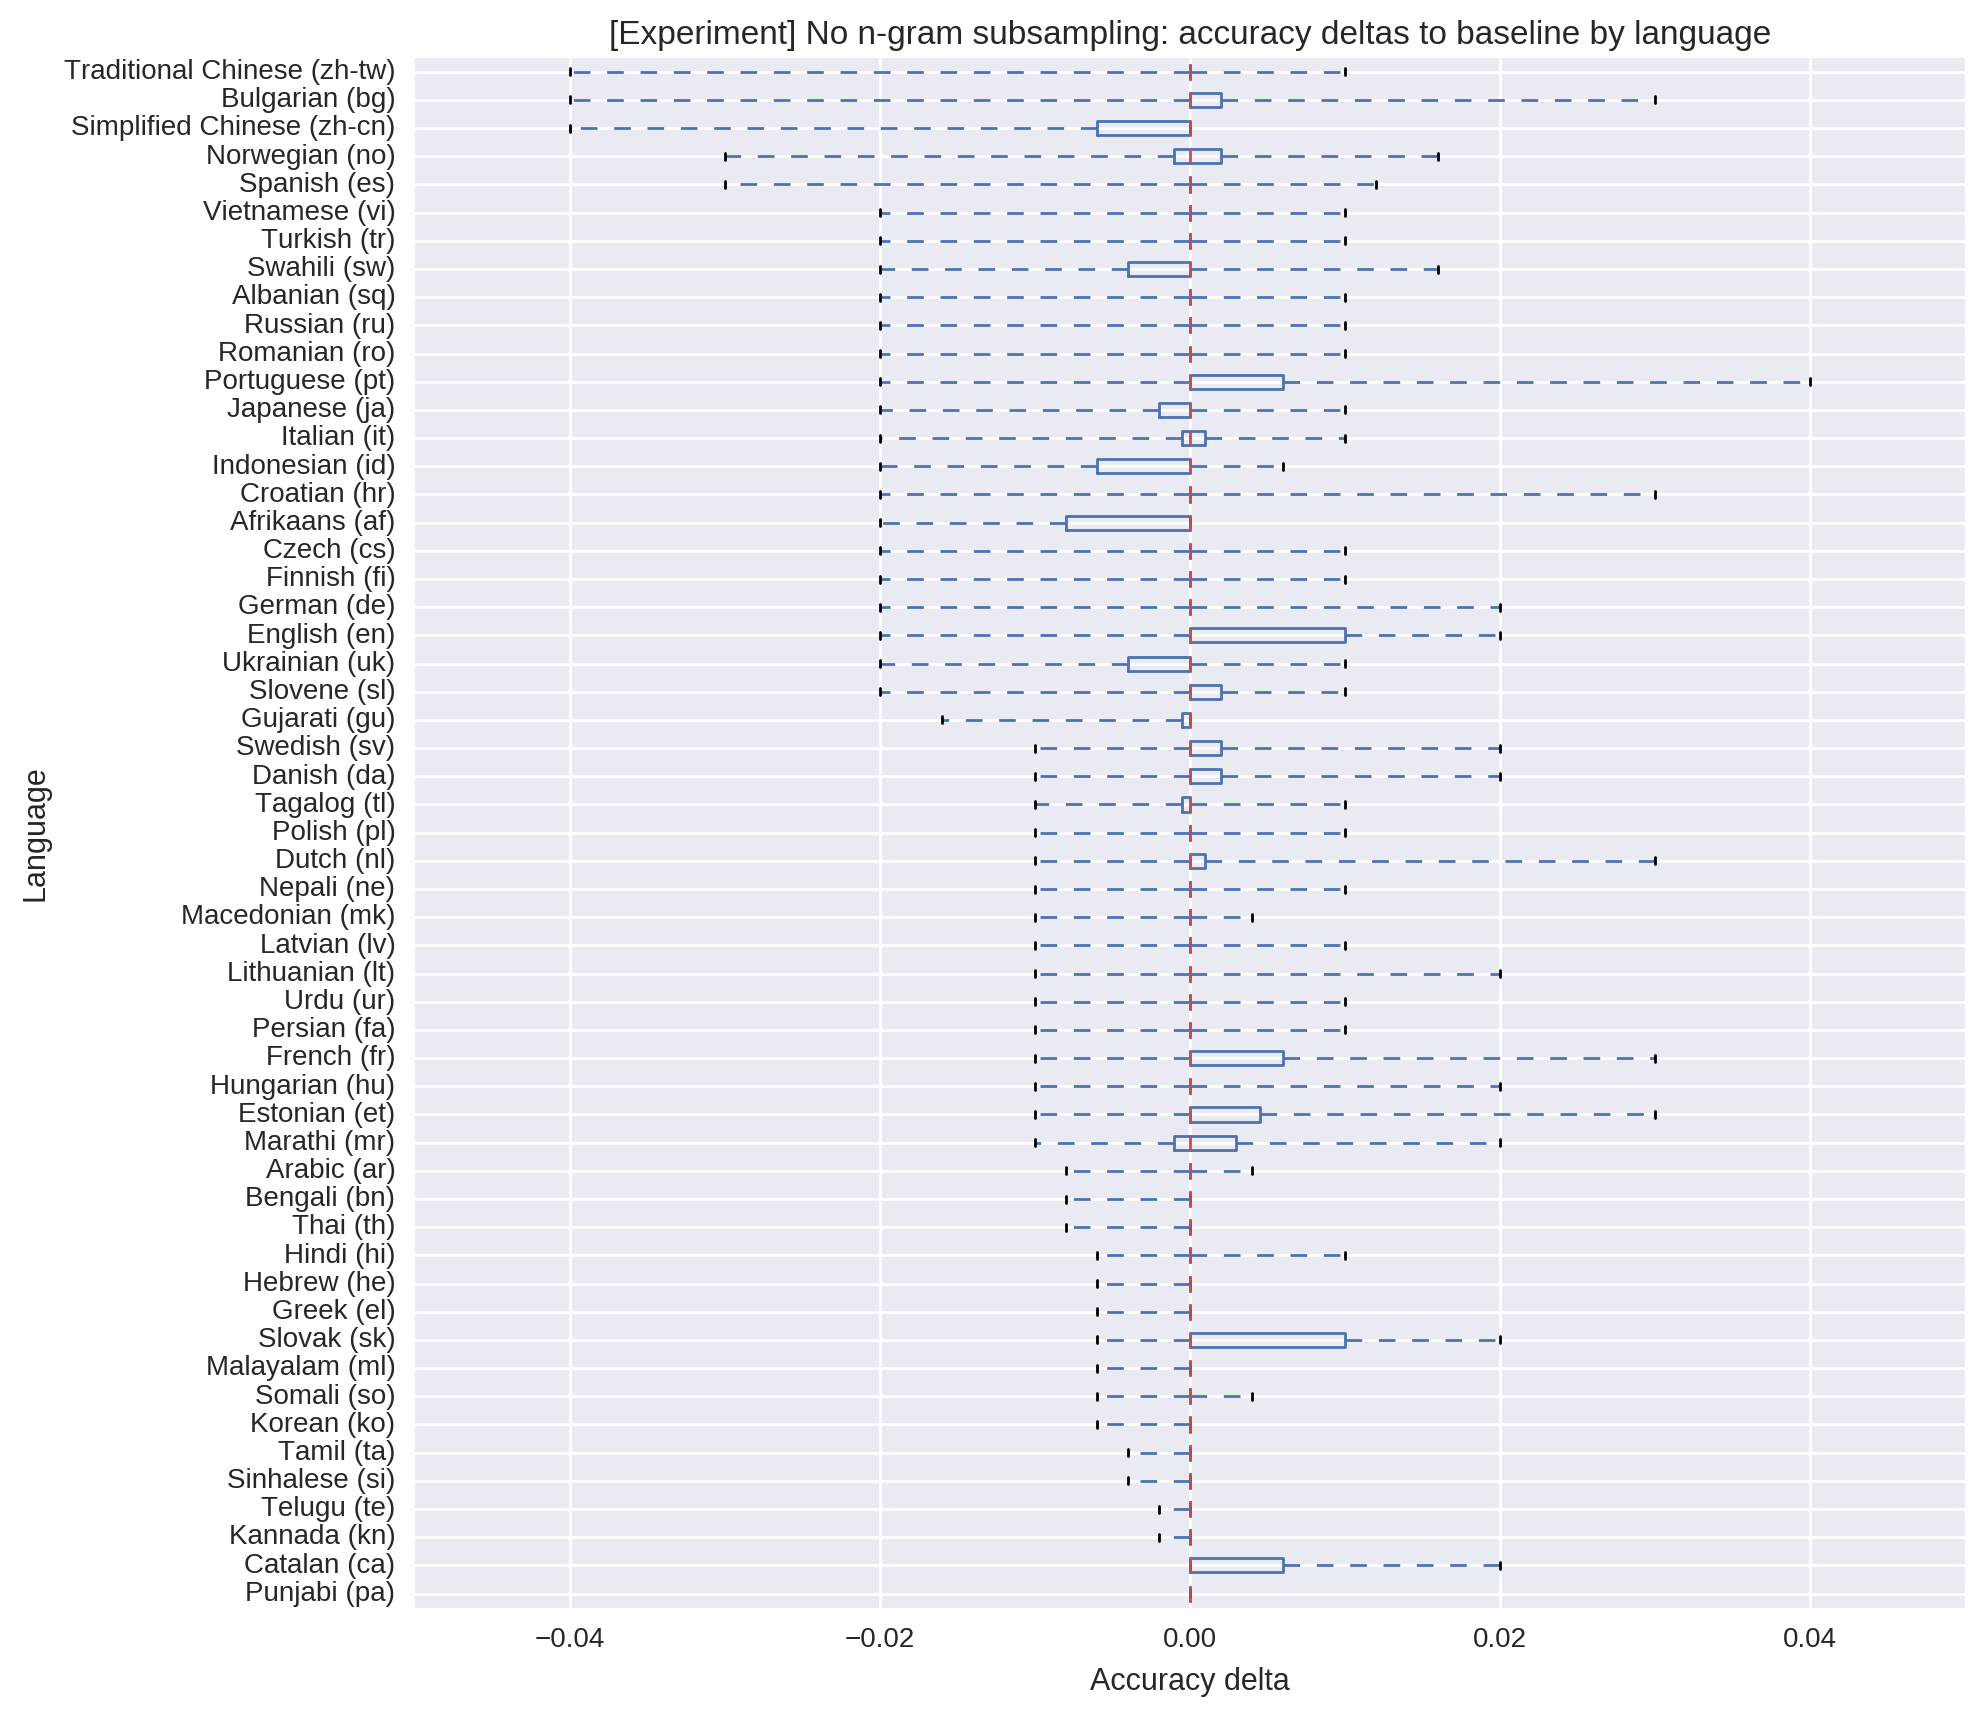

In [80]:
def plot_accuracy_deltas_by_language(baseline_results, experiment_results, experiment_name,
                                     order='min', baseline_desc=None):
    baseline_accuracies = extract_accuracies(baseline_results)
    deltas = (extract_accuracies(experiment_results) - baseline_accuracies).dropna(axis=1, how='all')
    delta_counts = pd.Series({k: v.sum().sum() for k, v in dict(positive=deltas > 0,
                                                                negative=deltas < 0,
                                                                zero=deltas == 0).items()})
    delta_means = deltas.mean()
    delta_mean_counts = pd.Series(dict(positive=(delta_means > 0).sum(),
                                       negative=(delta_means < 0).sum(),
                                       zero=(delta_means == 0).sum()))
    print('Result summary (positive is better than the baseline)\n')
    print('Number of results: {}'.format(delta_counts.sum()))
    print('Number of languages: {}'.format(len(deltas.columns)))
    print('Mean non-zero delta: {:4f}'.format(deltas[deltas != 0].mean().mean()))
    display(pd.DataFrame({
        'Delta count': delta_counts,
        'Delta percent': delta_counts / delta_counts.sum(),
        'Language mean delta count': delta_mean_counts,
        'Language mean delta percent': delta_mean_counts / delta_mean_counts.sum()
    }))

    if order == 'width':
        order_series = deltas.max() - deltas.min()
    else:
        order_series = getattr(deltas, order)()
    ax = deltas[order_series.sort_values(ascending=False).index].plot(
        kind='box', vert=False, figsize=(10, 10), whis='range'
    )
    positive_limit = deltas.abs().max().max() + 0.01
    # Keep the x-axis symmetrical
    ax.set_xlim((-positive_limit, positive_limit))
    ax.set_xlabel('Accuracy delta')
    ax.set_ylabel('Language')
    ax.set_title('{} accuracy deltas to baseline{} by language'.format(
        experiment_name,
        ' ({})'.format(baseline_desc) if baseline_desc else ''
    ))

plot_accuracy_deltas_by_language(baseline_results,
                                 no_ngram_subsampling_results,
                                 '[Experiment] No n-gram subsampling:')

Result summary (positive is better than the baseline)

Number of results: 1140
Number of languages: 55
Mean non-zero delta: -0.000920


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,365,0.320175,35,0.636364
positive,280,0.245614,19,0.345455
zero,495,0.434211,1,0.018182


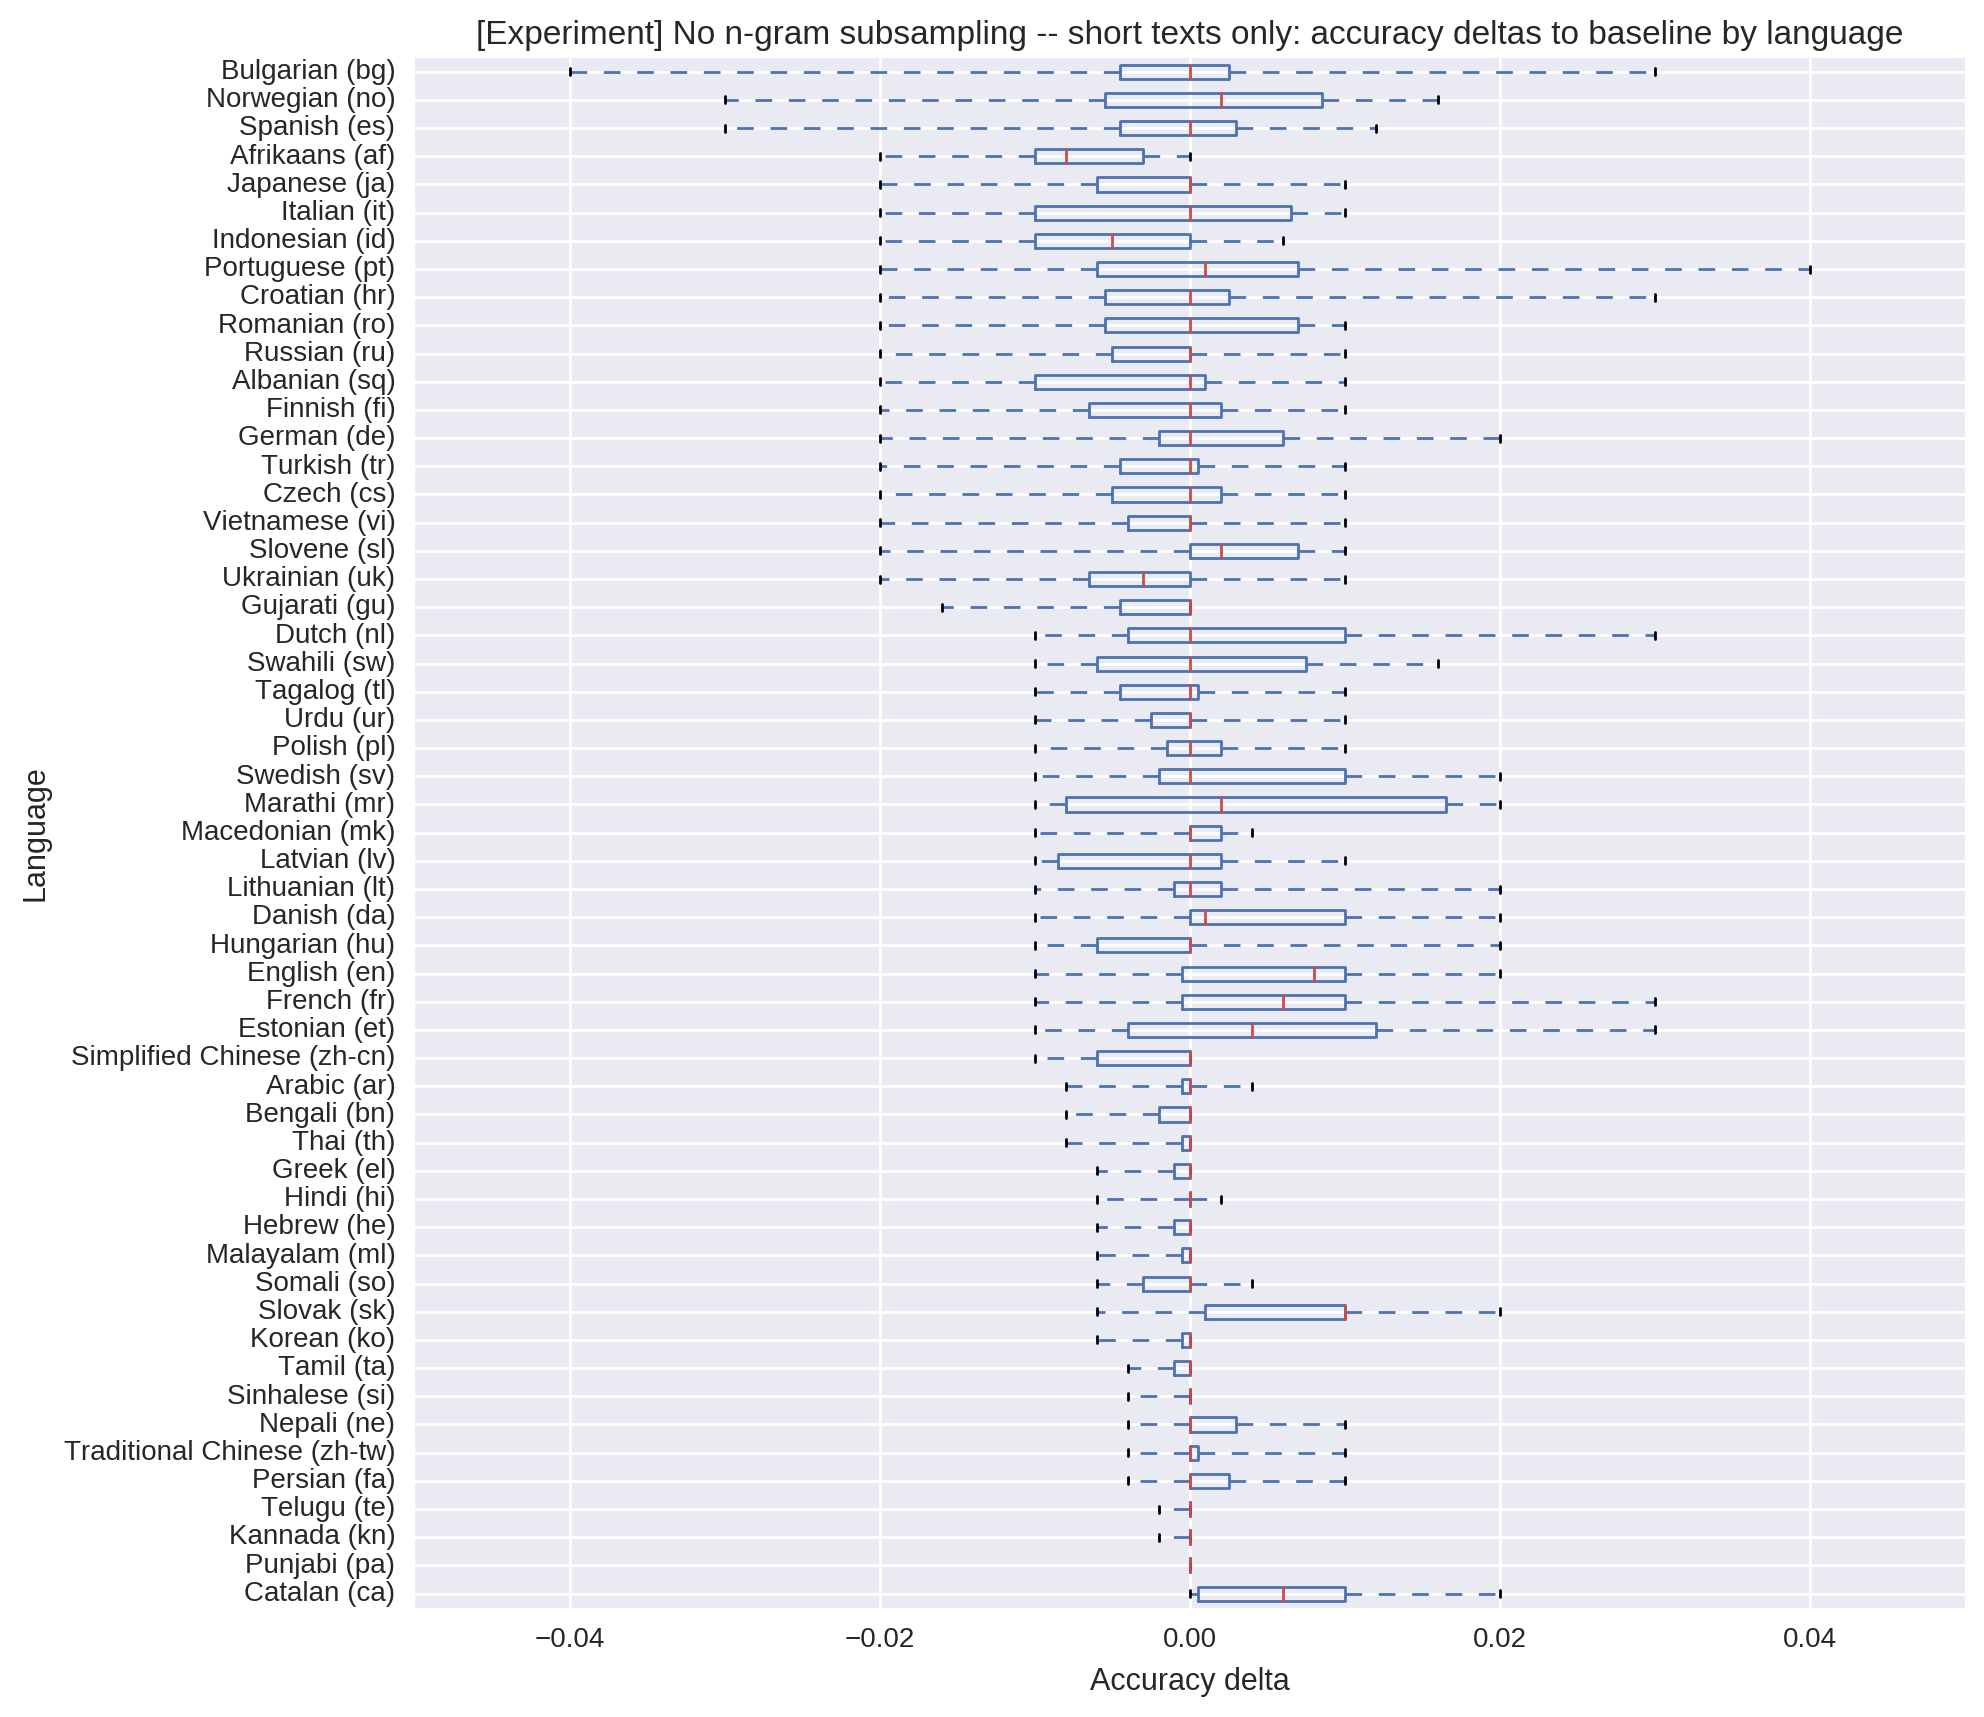

In [81]:
# Setting the default min_length to 1 because min_length=0 includes the full texts.
def filter_results_by_substring_length(results, min_length=1, max_length=20):
    return results[(min_length <= results['substringLength']) & (results['substringLength'] <= max_length)]

plot_accuracy_deltas_by_language(filter_results_by_substring_length(baseline_results),
                                 filter_results_by_substring_length(no_ngram_subsampling_results),
                                 '[Experiment] No n-gram subsampling -- short texts only:')

## Experiment #2: Merging language profiles

Unlike the previous experiment, for this experiment we need to compare baseline results by profile (i.e., the short and default profile results shouldn't be grouped). Two approaches to merging the profiles are tested: as a sum of counts, or as a sum of counts divided by the number of ngrams of each length (which are then converted back to integers to minimise changes to the Java code). It looks like the latter approach generally improves performance, though there are some exceptions.

Result summary (positive is better than the baseline)

Number of results: 495
Number of languages: 45
Mean non-zero delta: 0.003375


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,110,0.222222,23,0.511111
positive,113,0.228283,18,0.400000
zero,272,0.549495,4,0.088889


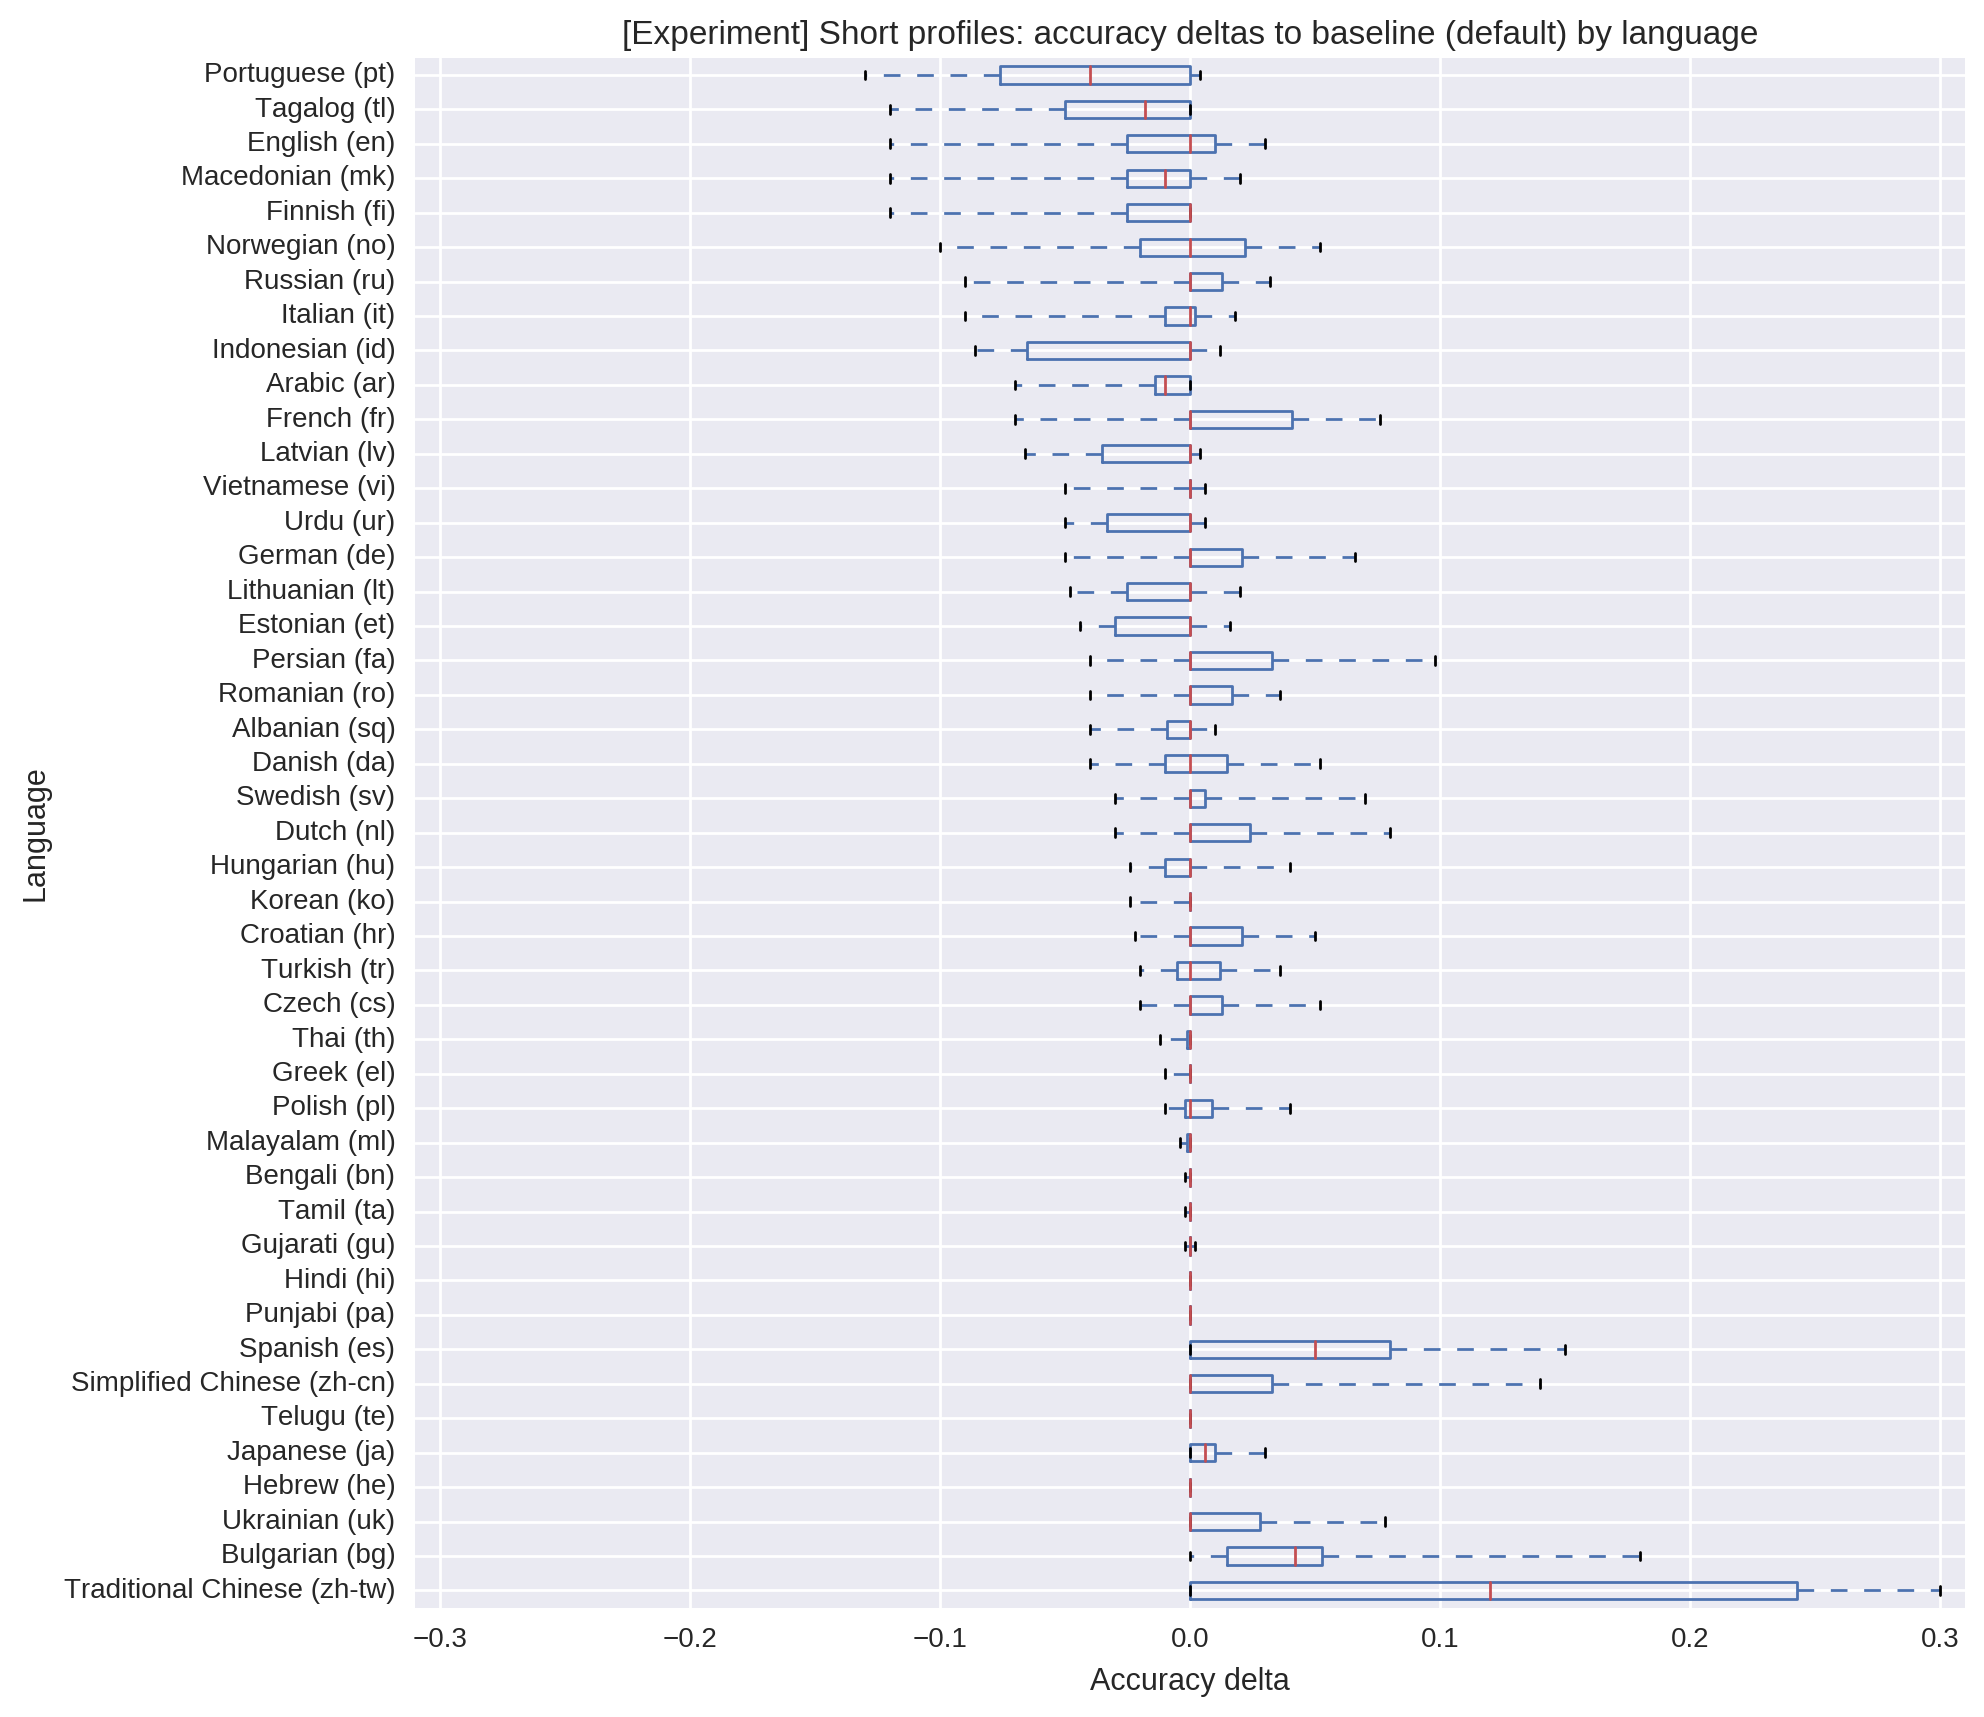

In [82]:
default_baseline_results = baseline_results[~baseline_results['useShortProfile'] &
                                            ~baseline_results['useAllLanguages']]
default_baseline_results.index = range(len(default_baseline_results))
short_baseline_results = baseline_results[baseline_results['useShortProfile'] &
                                          ~baseline_results['useAllLanguages']]
short_baseline_results.index = range(len(short_baseline_results))

plot_accuracy_deltas_by_language(
    default_baseline_results,
    short_baseline_results,
    '[Experiment] Short profiles:',
    order='min',
    baseline_desc='default'
)

In [10]:
from collections import Counter, defaultdict
import json
import os
import shutil

import numpy as np

RESOURCE_DIR = '../src/main/resources/langdetect'

def merge_language_profiles(how):
    merged_dir = os.path.join(RESOURCE_DIR, 'merged-{}'.format(how))
    shutil.rmtree(merged_dir, ignore_errors=True)
    os.mkdir(merged_dir)
    for lang in os.listdir(RESOURCE_DIR):
        if not os.path.exists(os.path.join(RESOURCE_DIR, 'short-text', lang)):
            continue
        with open(os.path.join(RESOURCE_DIR, lang), encoding='utf-8') as default_file, \
             open(os.path.join(RESOURCE_DIR, 'short-text', lang), encoding='utf-8') as short_file:
            default_profile = json.load(default_file)
            short_profile = json.load(short_file)
        assert default_profile['name'] == short_profile['name'] and default_profile['name'] == lang
        if how == 'sum':
            freq_df = pd.DataFrame(dict(default=default_profile['freq'],
                                        short=short_profile['freq'])).fillna(0)
            merged_profile = dict(
                name=lang,
                n_words=(np.array(default_profile['n_words']) + np.array(short_profile['n_words'])).tolist(),
                freq={k: int(v) for k, v in (freq_df['default'] + freq_df['short']).items()}
            )
        elif how == 'average':
            merged_profile = dict(name=lang, freq=defaultdict(float))
            for profile in (short_profile, default_profile):
                for ngram, count in profile['freq'].items():
                    merged_profile['freq'][ngram] += count / profile['n_words'][len(ngram) - 1]
            len_to_min_freq = [float('inf')] * 3
            for ngram, freq in merged_profile['freq'].items():
                len_to_min_freq[len(ngram) - 1] = min(len_to_min_freq[len(ngram) - 1], freq)
            merged_profile['n_words'] = [0, 0, 0]
            for ngram in merged_profile['freq']:
                count = int(merged_profile['freq'][ngram] / len_to_min_freq[len(ngram) - 1])
                merged_profile['freq'][ngram] = count
                merged_profile['n_words'][len(ngram) - 1] += count
        with open(os.path.join(merged_dir, lang), 'w', encoding='utf-8') as out_file:
            json.dump(merged_profile, out_file, ensure_ascii=False, separators=',:')

merge_language_profiles('sum')
merge_language_profiles('average')

In [46]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=profile-merged-sum \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/profile-merged-sum.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 18.232 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


Result summary (positive is better than the baseline)

Number of results: 495
Number of languages: 45
Mean non-zero delta: 0.008907


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,65,0.131313,15,0.333333
positive,96,0.193939,23,0.511111
zero,334,0.674747,7,0.155556


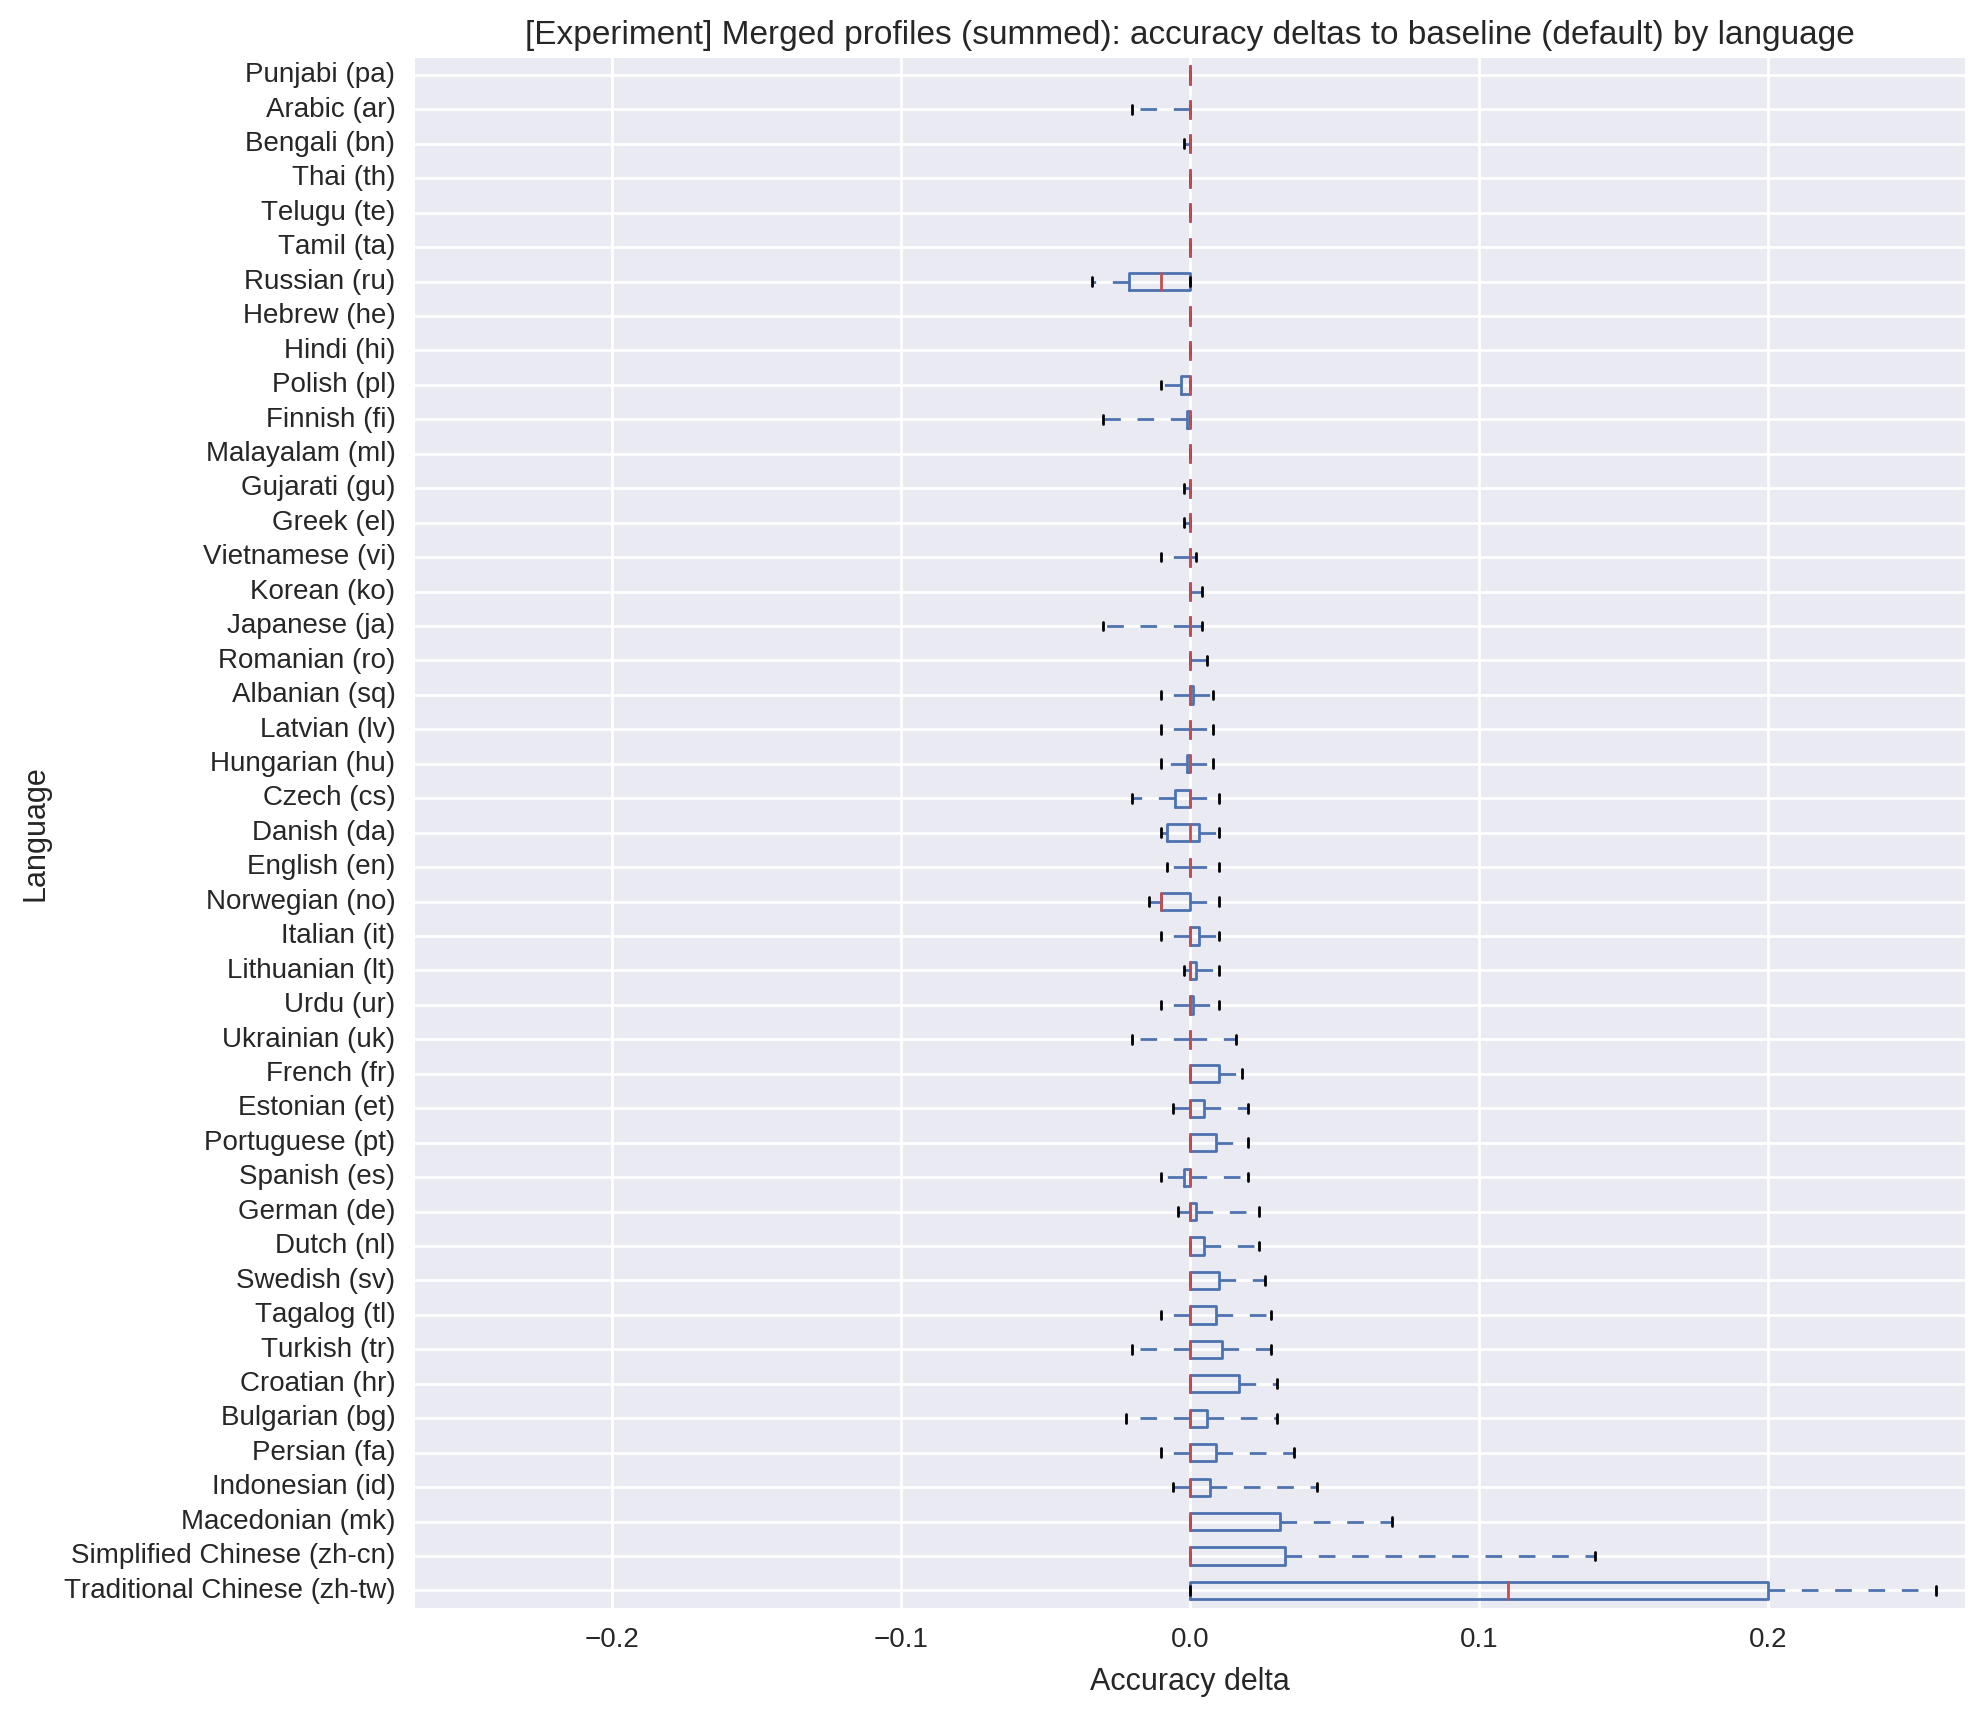

In [83]:
profile_merged_sum_results = pd.read_csv('results/profile-merged-sum.csv')
plot_accuracy_deltas_by_language(
    default_baseline_results,
    profile_merged_sum_results.dropna(axis=1, how='all'),
    '[Experiment] Merged profiles (summed):',
    order='max',
    baseline_desc='default'
)

Result summary (positive is better than the baseline)

Number of results: 495
Number of languages: 45
Mean non-zero delta: 0.003492


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,101,0.204040,18,0.400000
positive,117,0.236364,21,0.466667
zero,277,0.559596,6,0.133333


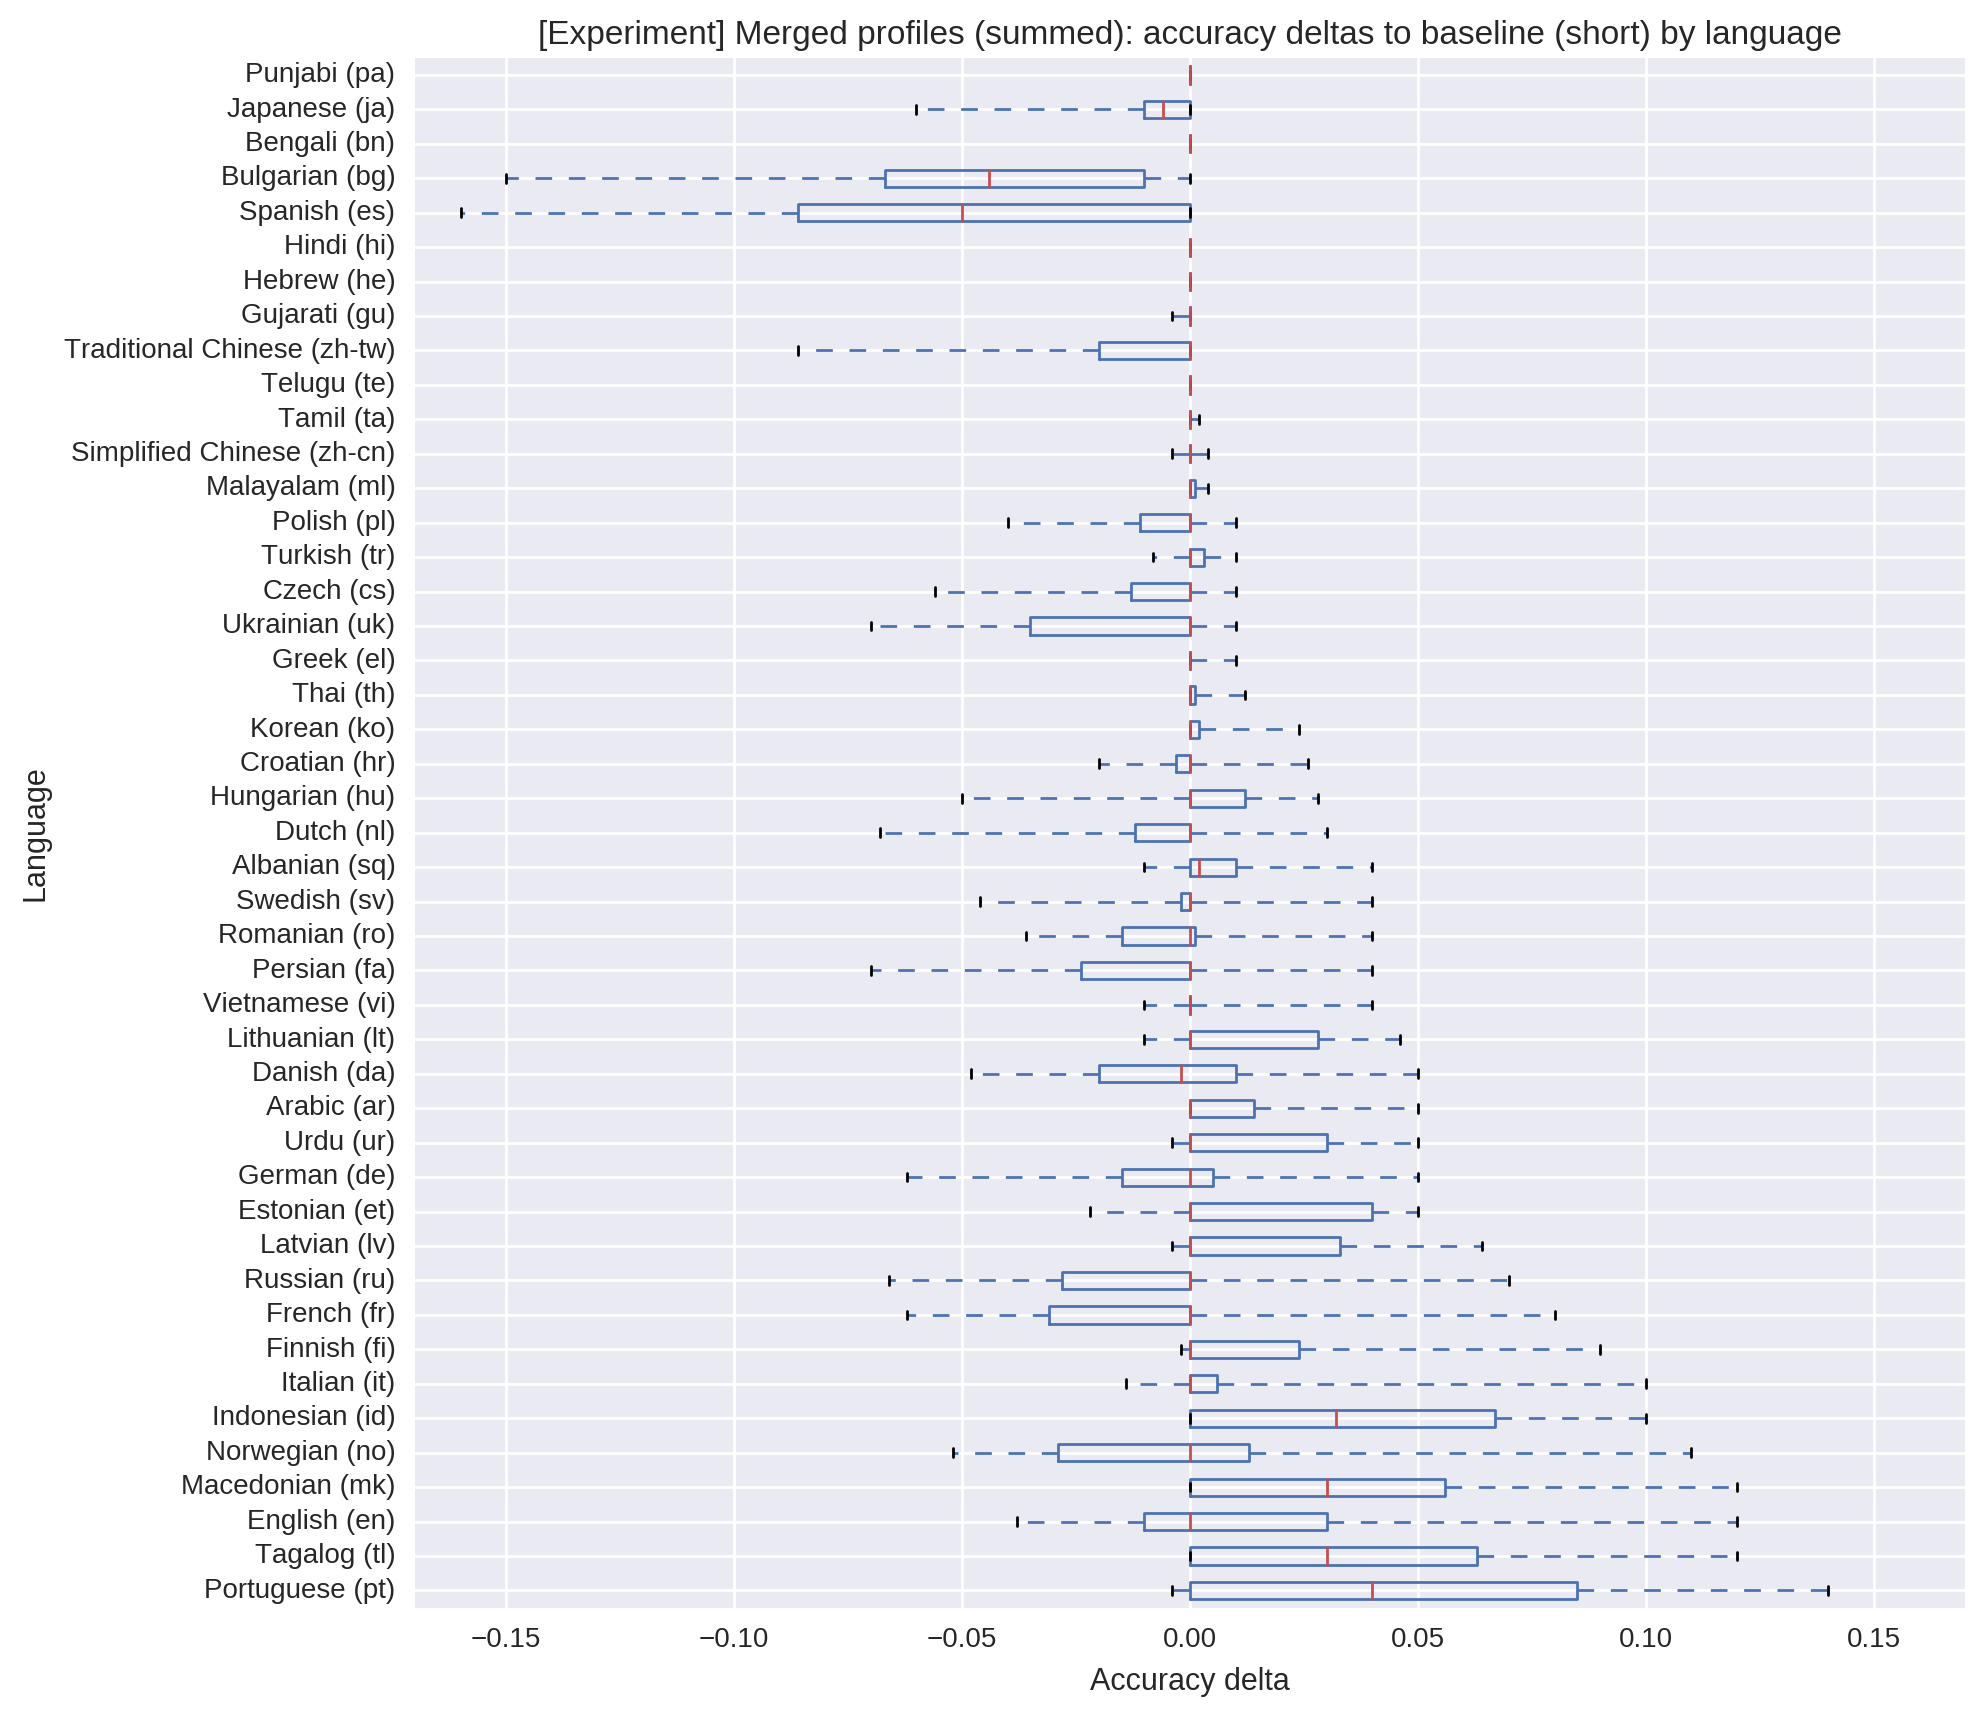

In [84]:
plot_accuracy_deltas_by_language(
    short_baseline_results,
    profile_merged_sum_results.dropna(axis=1, how='all'),
    '[Experiment] Merged profiles (summed):',
    order='max',
    baseline_desc='short'
)

In [49]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=profile-merged-average \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/profile-merged-average.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 18.798 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


Result summary (positive is better than the baseline)

Number of results: 495
Number of languages: 45
Mean non-zero delta: 0.015144


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,72,0.145455,11,0.244444
positive,134,0.270707,28,0.622222
zero,289,0.583838,6,0.133333


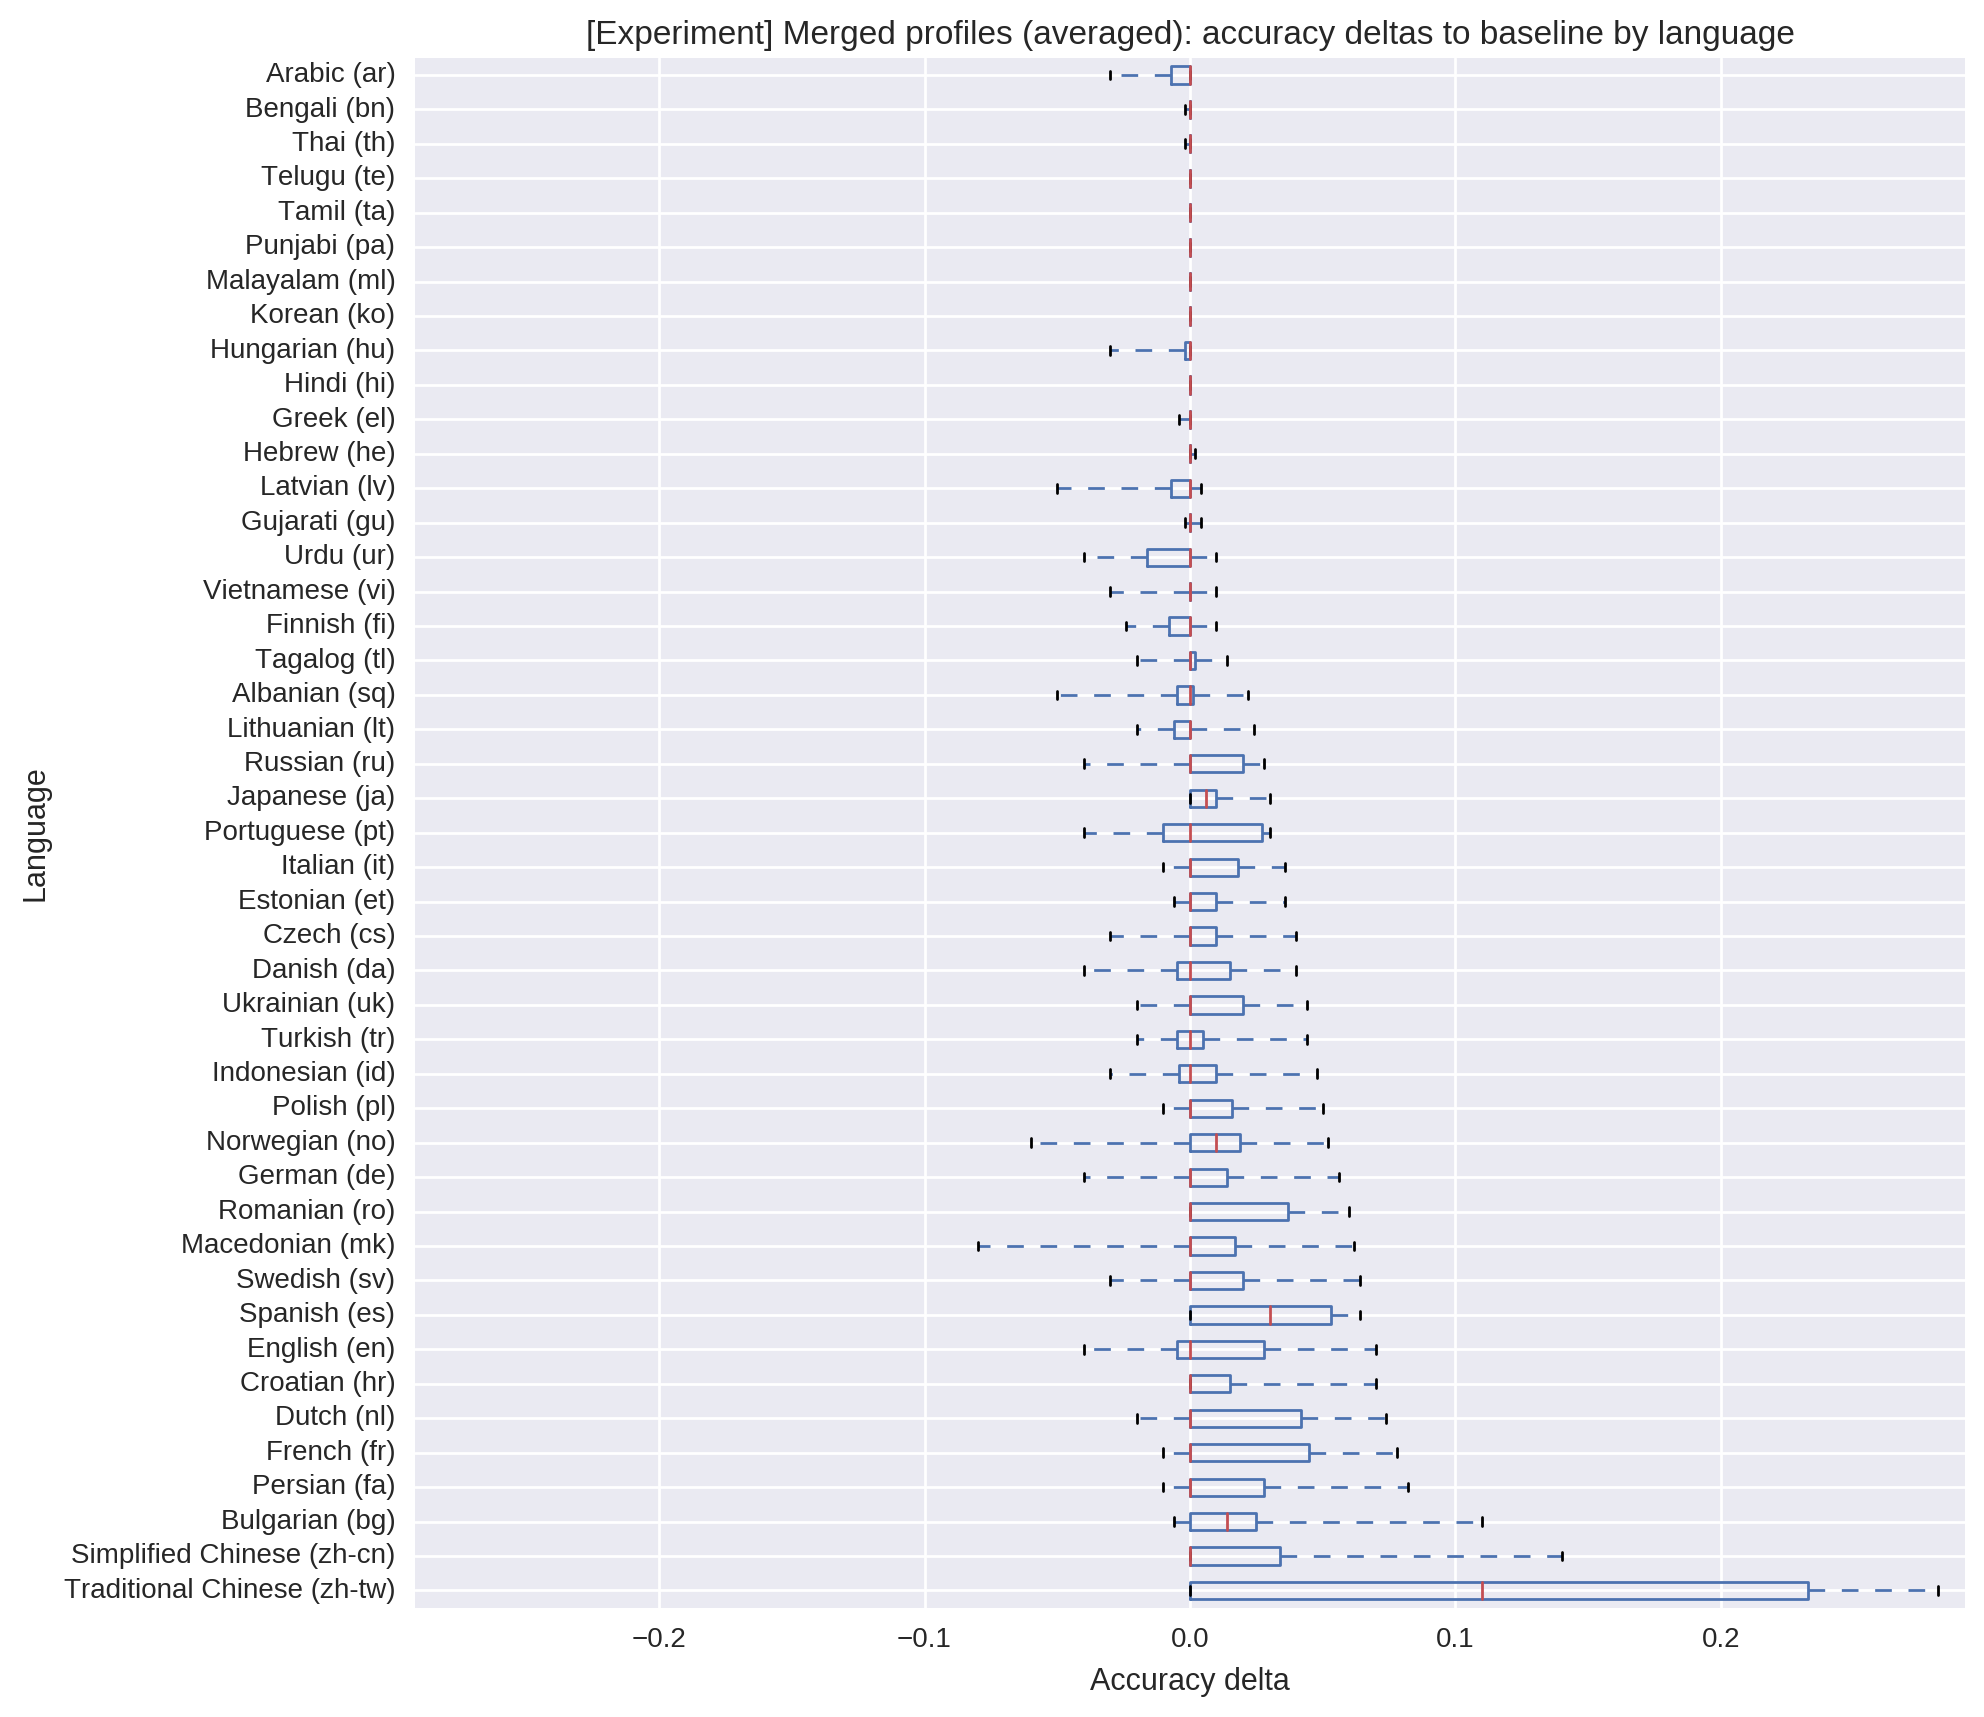

In [85]:
profile_merged_average_results = pd.read_csv('results/profile-merged-average.csv')
plot_accuracy_deltas_by_language(
    default_baseline_results,
    profile_merged_average_results.dropna(axis=1, how='all'),
    '[Experiment] Merged profiles (averaged):',
    order='max'
)

Result summary (positive is better than the baseline)

Number of results: 495
Number of languages: 45
Mean non-zero delta: 0.010945


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,61,0.123232,10,0.222222
positive,144,0.290909,29,0.644444
zero,290,0.585859,6,0.133333


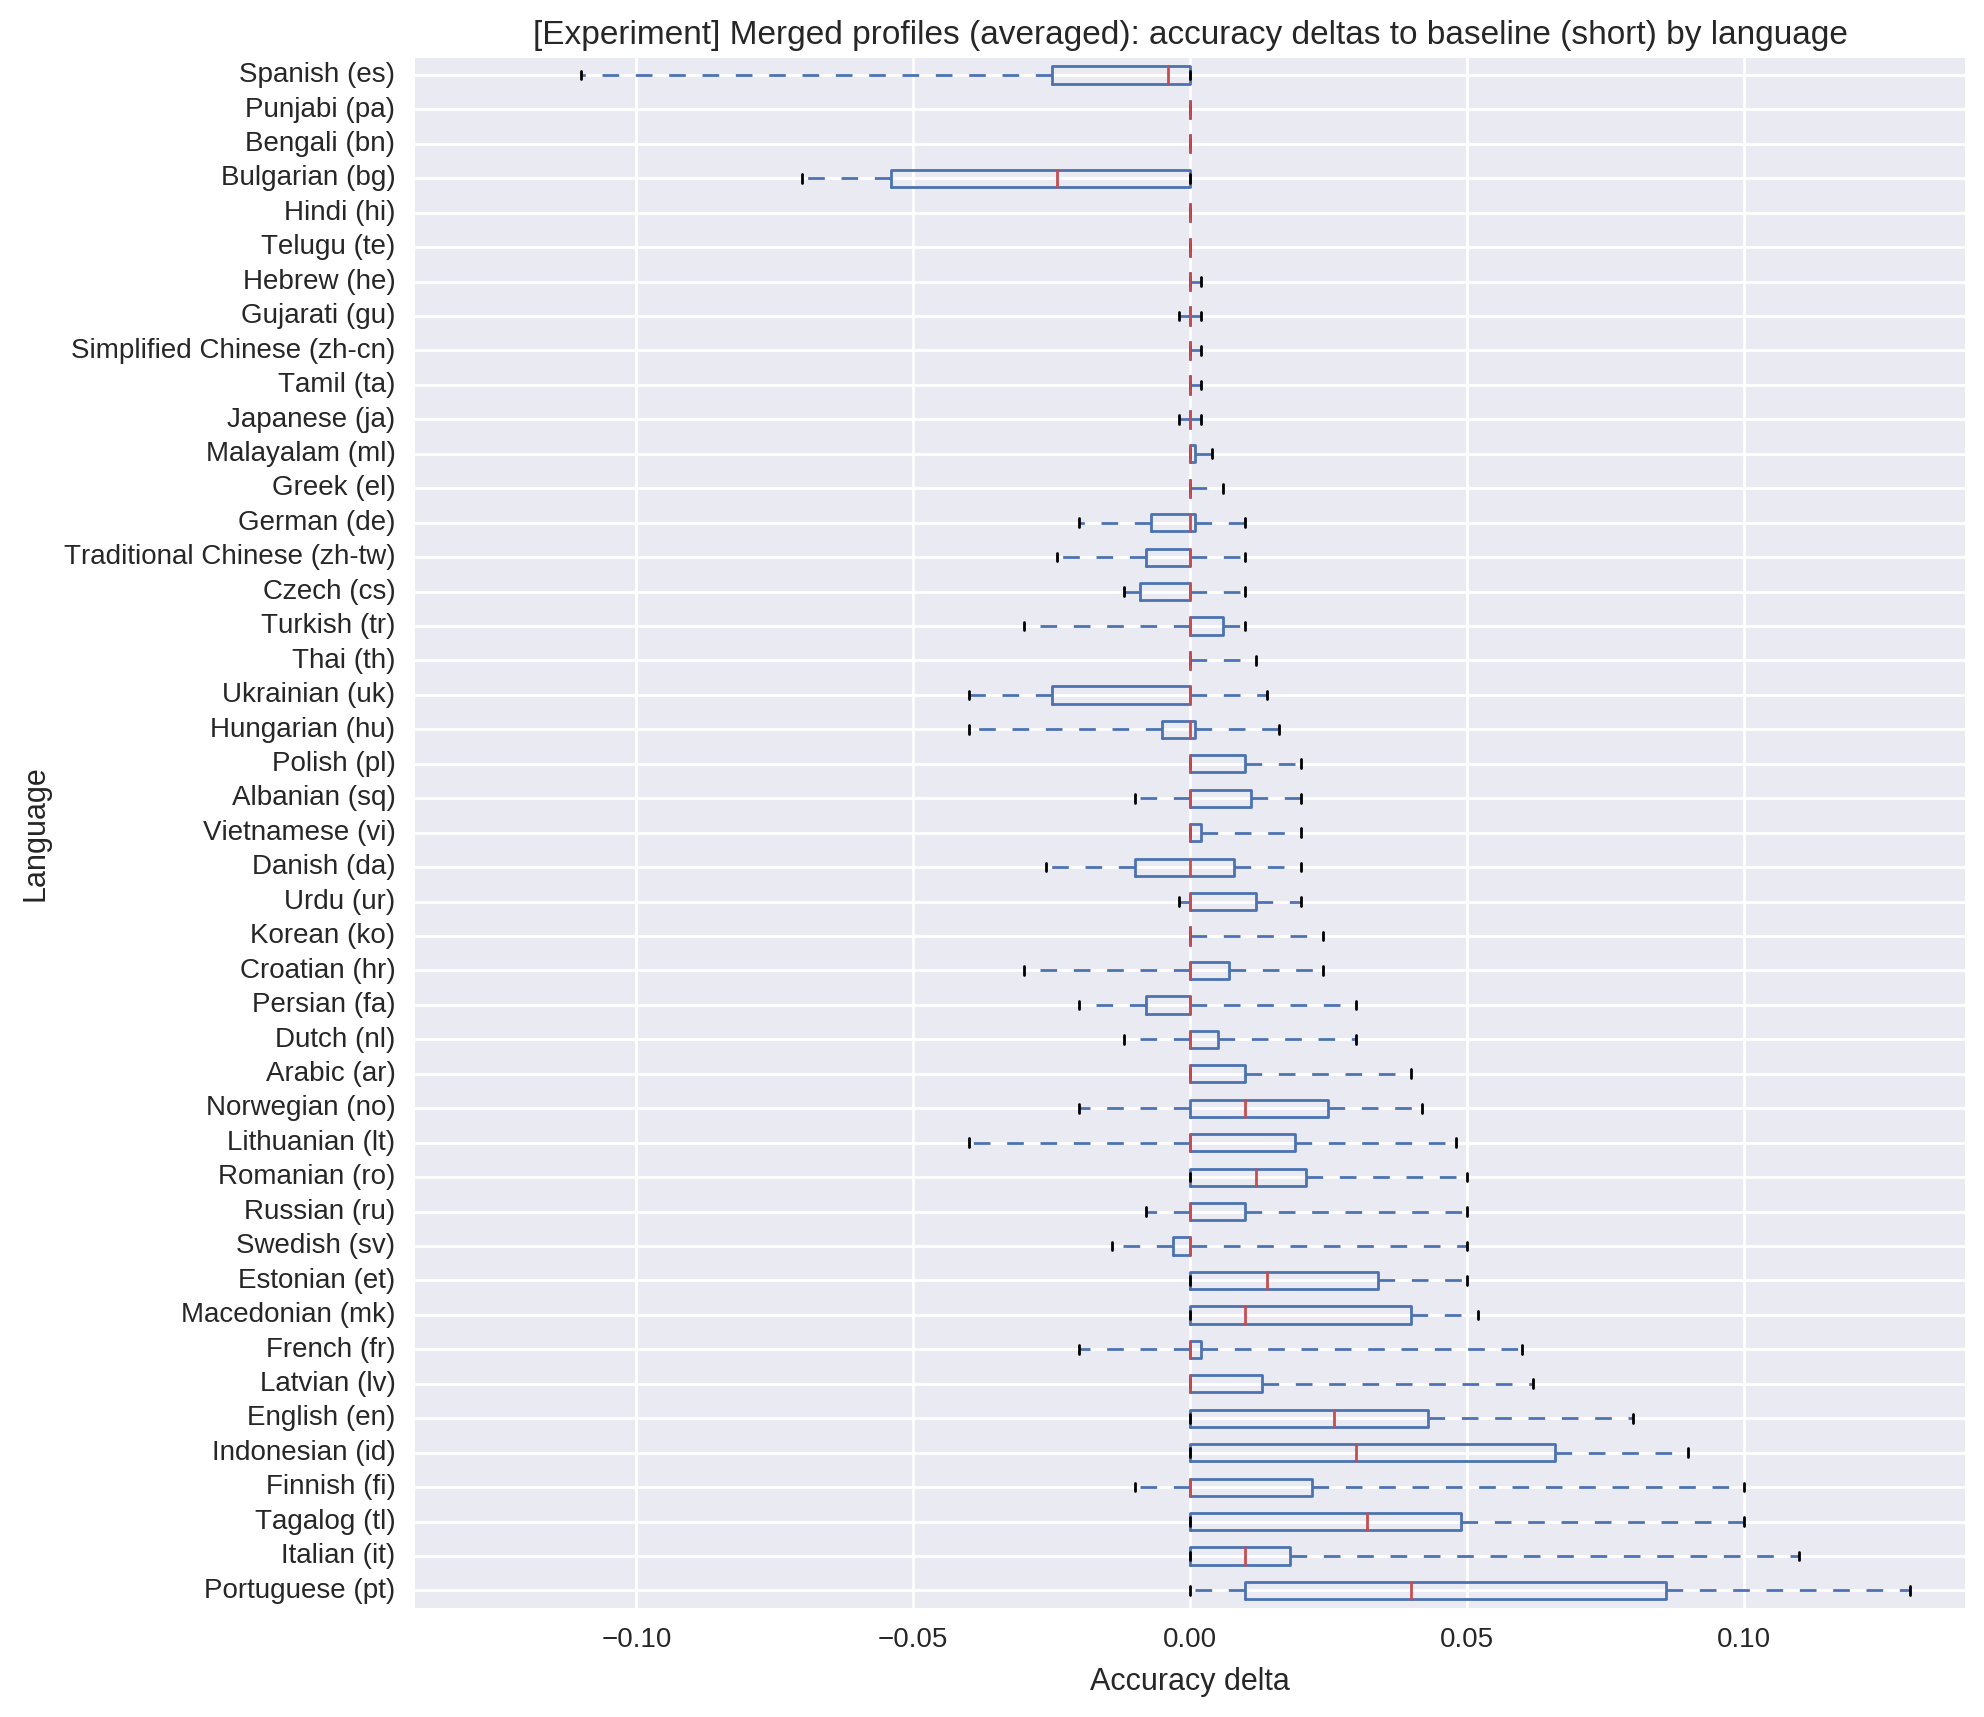

In [86]:
plot_accuracy_deltas_by_language(
    short_baseline_results,
    profile_merged_average_results.dropna(axis=1, how='all'),
    '[Experiment] Merged profiles (averaged):',
    order='max',
    baseline_desc='short'
)

### Digging deeper into the issue with Chinese

* Way more n-grams in the short profile
* Some common characters like 不 (not? https://en.wiktionary.org/wiki/%E4%B8%8D) are missing from the short profile, and the default profile seems to have fewer latin characters (maybe because they were removed from texts where they are infrequent? see https://github.com/shuyo/language-detection/blob/master/src/com/cybozu/labs/langdetect/util/LangProfile.java#L73)

In [52]:
def read_freq_df(lang):
    with open(os.path.join(RESOURCE_DIR, lang), encoding='utf-8') as default_file, \
         open(os.path.join(RESOURCE_DIR, 'short-text', lang), encoding='utf-8') as short_file:
        default_profile = json.load(default_file)
        short_profile = json.load(short_file)
    return pd.DataFrame(dict(default=default_profile['freq'], short=short_profile['freq']))

zh_tw_df = read_freq_df('zh-tw')

In [53]:
zh_tw_df.describe()

,default,short
count,2104.000000,18696.000000
mean,3375.504278,75.664848
std,9531.354034,716.257545
min,584.000000,5.000000
25%,828.750000,7.000000
50%,1293.500000,12.000000
75%,2849.000000,26.000000
max,211682.000000,46264.000000


In [55]:
zh_tw_df.sort_values('default', ascending=False).head(10)

,default,short
，,211682.0,5421.0
的,145617.0,8173.0
丈,143774.0,1543.0
丁,112603.0,26810.0
丕,96789.0,91.0
。,93215.0,2414.0
丞,85837.0,44.0
於,85512.0,NaN
、,80530.0,632.0
不,69580.0,NaN


In [56]:
zh_tw_df.sort_values('short', ascending=False).head(10)

,default,short
三,7943.0,46264.0
之,17356.0,35997.0
並,6623.0,29596.0
t,NaN,28536.0
丁,112603.0,26810.0
亂,NaN,15557.0
o,NaN,14889.0
亞,10406.0,13171.0
丹,NaN,12021.0
h,NaN,11570.0


## Experiment #3: Multiple language profiles on the classifier level

Simple change to the Java code: allow loading multiple profiles for the same language and just treat them as different classes.

In [57]:
%%bash

cd ..
gradle test --rerun-tasks \
    -Dexperiment.name=profile-,short-text \
    -Dtest.single=DetectLanguageAccuracyTest \
    -Dpath.accuracies.out=experiments/results/profile-combined.csv

:compileJava
:processResources
:classes
:compileTestJava
:processTestResources
:testClasses
:test

BUILD SUCCESSFUL

Total time: 35.773 secs

This build could be faster, please consider using the Gradle Daemon: https://docs.gradle.org/2.10/userguide/gradle_daemon.html


1 warning


Result summary (positive is better than the baseline)

Number of results: 495
Number of languages: 45
Mean non-zero delta: 0.016703


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,62,0.125253,12,0.266667
positive,129,0.260606,28,0.622222
zero,304,0.614141,5,0.111111


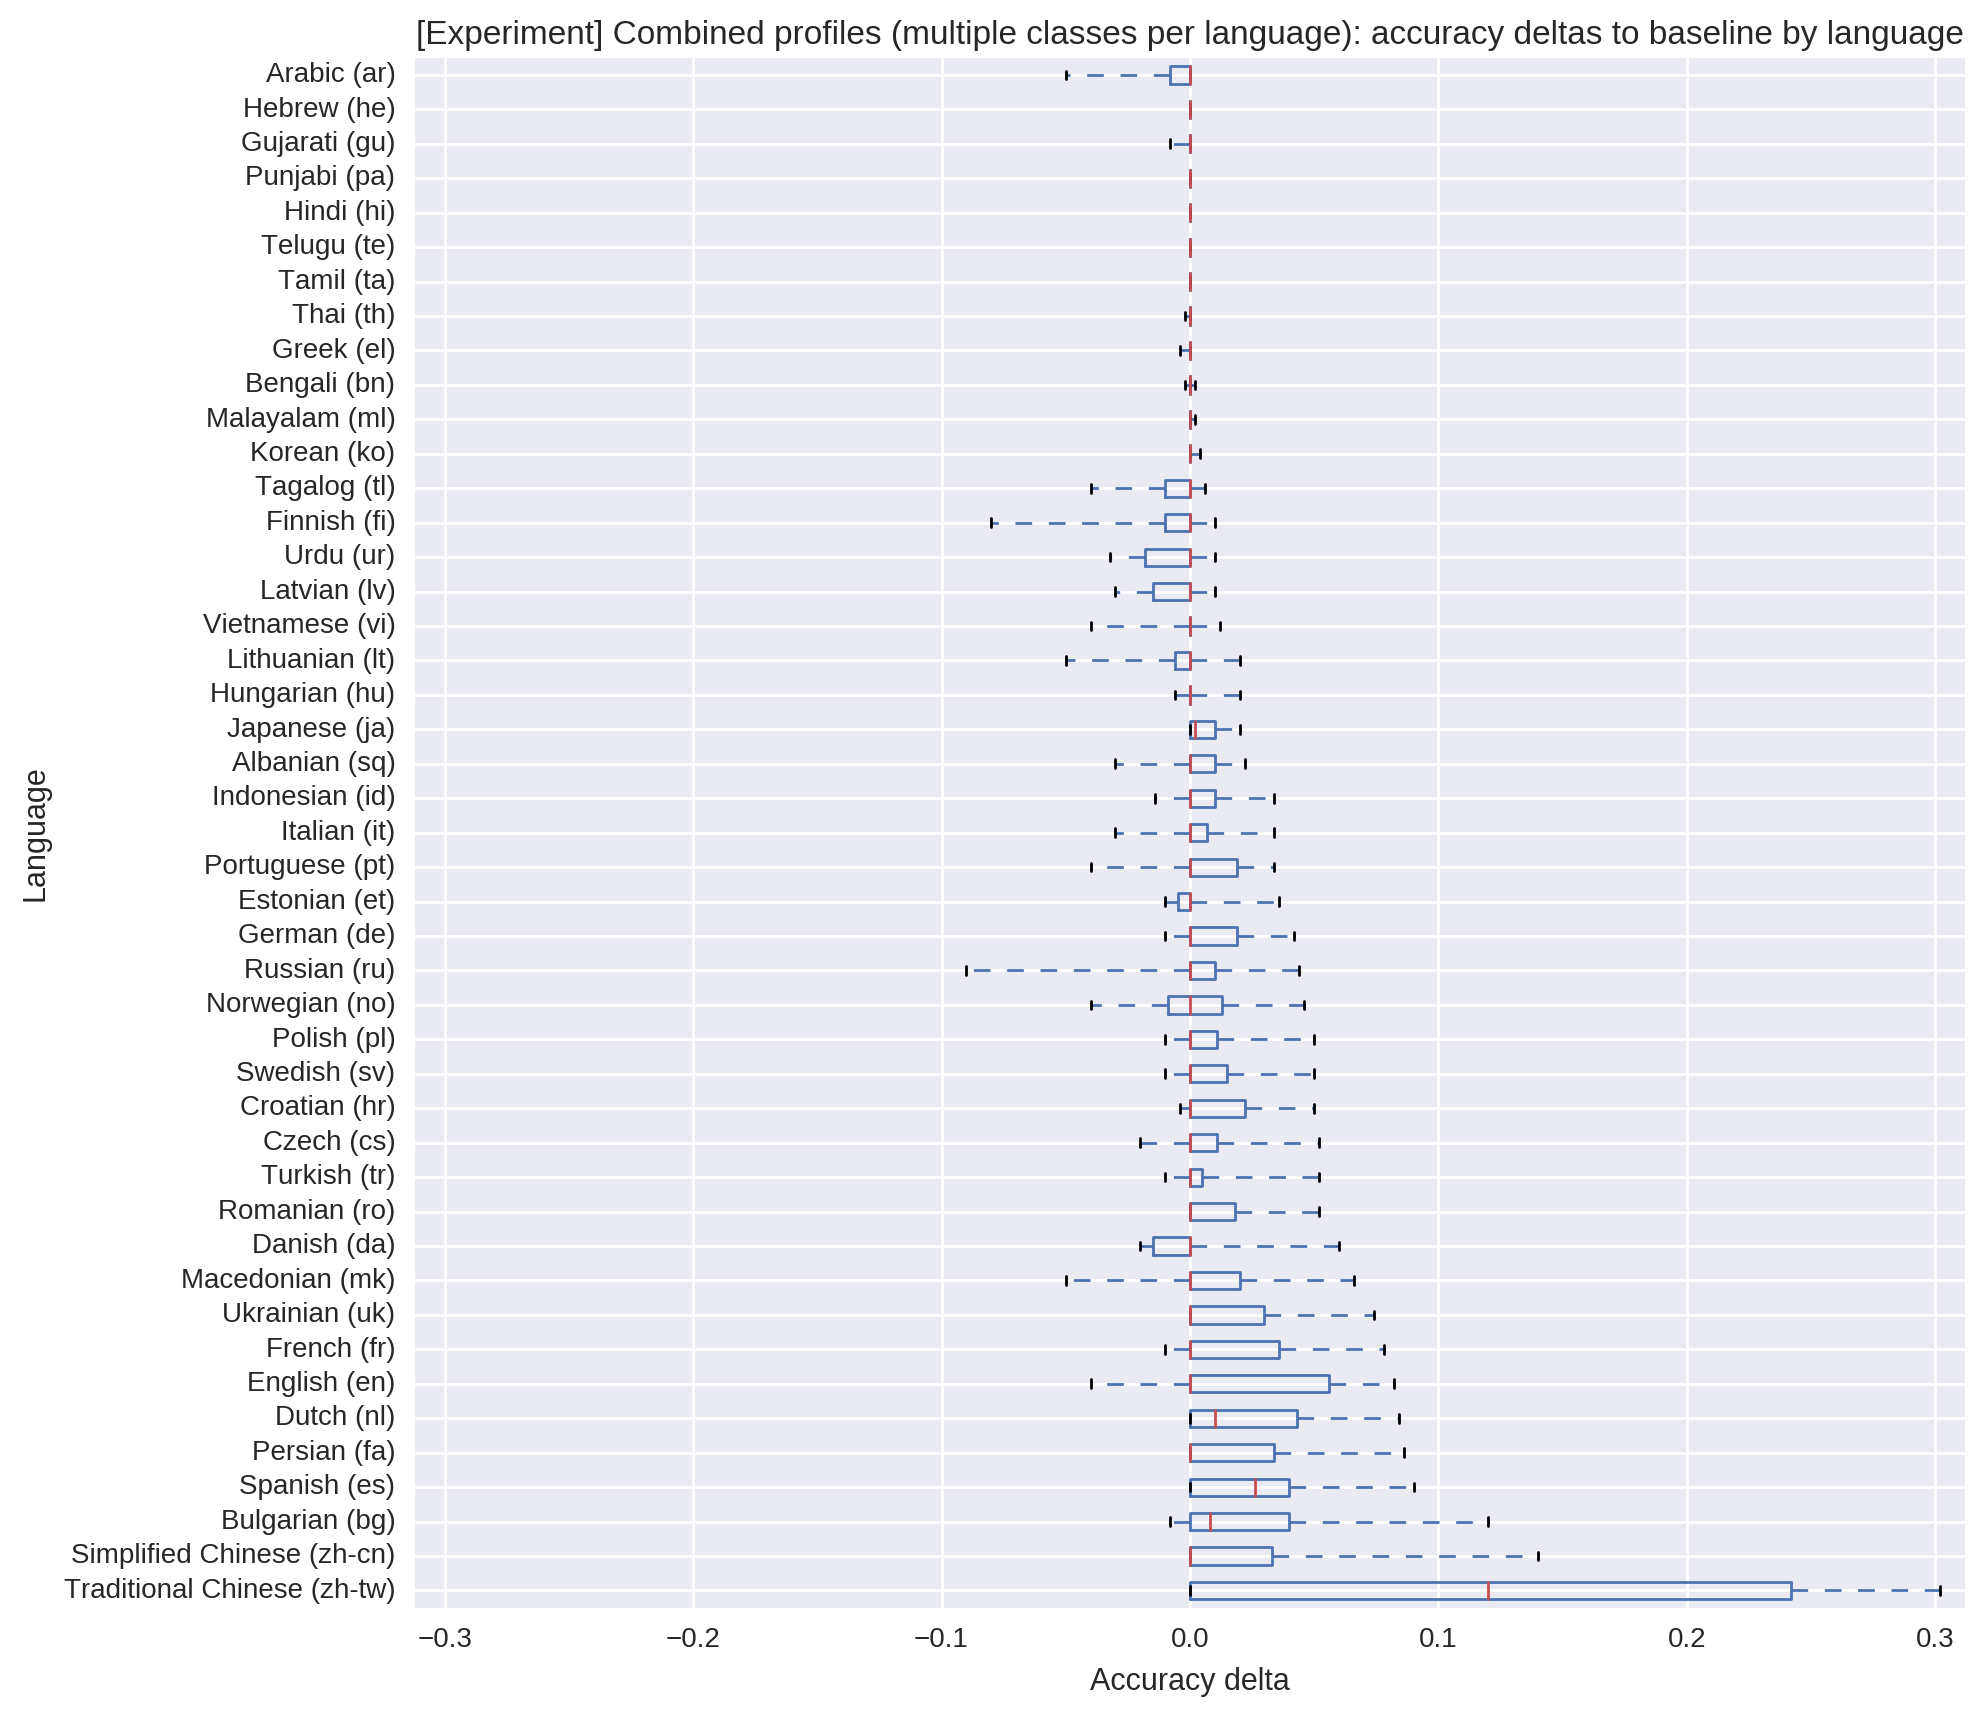

In [87]:
profile_combined_results = pd.read_csv('results/profile-combined.csv')
plot_accuracy_deltas_by_language(
    default_baseline_results,
    profile_combined_results,
    '[Experiment] Combined profiles (multiple classes per language):',
    order='max'
)

Result summary (positive is better than the baseline)

Number of results: 495
Number of languages: 45
Mean non-zero delta: 0.011366


,Delta count,Delta percent,Language mean delta count,Language mean delta percent
negative,58,0.117172,7,0.155556
positive,147,0.296970,34,0.755556
zero,290,0.585859,4,0.088889


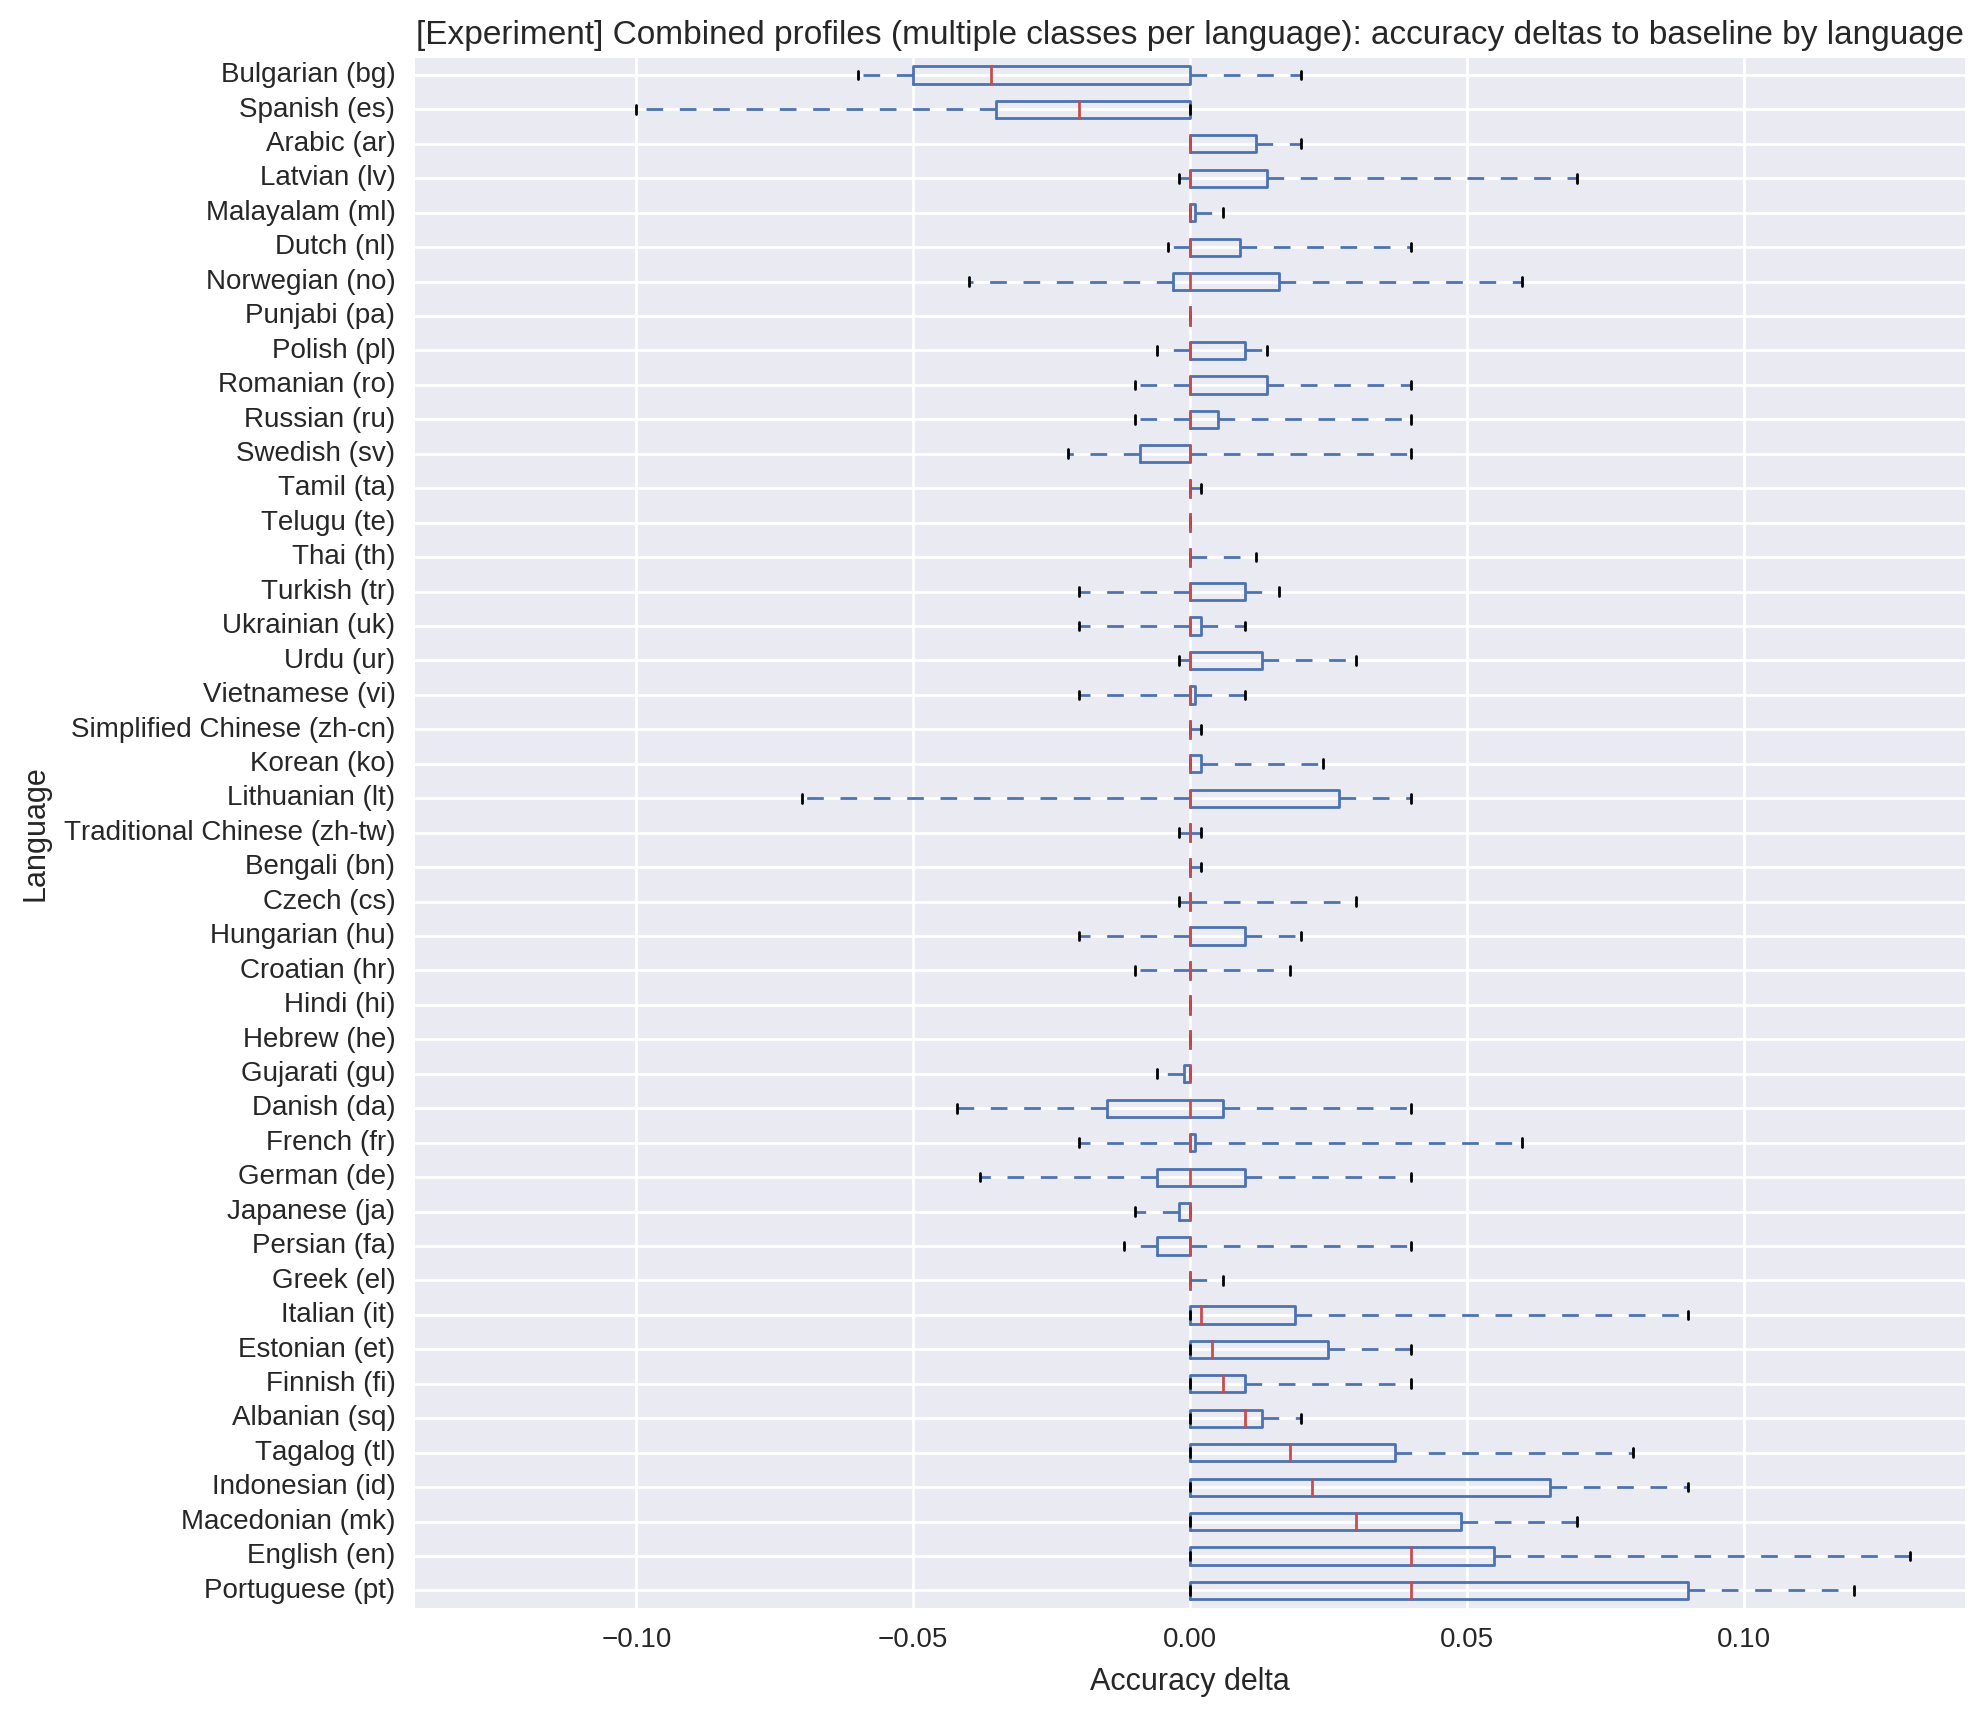

In [88]:
plot_accuracy_deltas_by_language(
    short_baseline_results,
    profile_combined_results,
    '[Experiment] Combined profiles (multiple classes per language):',
    order='median'
)